### Machine Learning Homework II

### 1. Decision Tree Classifier by Nathmath Huang (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : April 14, 2025

`P. Libraries`

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Optional, Callable

In [10]:
from copy import deepcopy

import lzma
import random
import matplotlib.pyplot as plt


In [2]:
# I have cuda
torch.cuda.is_available()

True

In [64]:
# Whether using `numpy` as the backend or `torch`
backend = "numpy"
device = "cpu"    
# For trees, do NOT use cuda since the latency between CPU and GPU is significant

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [3]:
# This object class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Object:
    """
    Base Type for all advanced n-dimensional data types.
    """
   
    __attr__ = "MML.Object"  
    
    def __init__(self):
        pass
   
    def __repr__(self):
        return f"Object (Abstract Data Type)."


In [4]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix(Object):
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    def __add__(self, other):
        """
        Element-wise addition.
        """
        return self._apply_op(other, lambda a, b: a + b)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        return self._apply_op(other, lambda a, b: a - b)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        return self._apply_op(other, lambda a, b: a * b)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        return self.__mul__(other)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        return self._apply_op(other, lambda a, b: a / b)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Matrix(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Matrix(self.data == other, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
    
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Matrix: A new matrix containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Matrix: A new matrix containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
            Matrix: A new matrix containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Matrix(result, backend=self._backend)    
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def repeat(self, repeats, axis=None):
        """
        Repeats the matrix elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Matrix: A new matrix with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
    
        Args:
            weights (array_like | Matrix): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Matrix: A new matrix with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Matrix(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Matrix(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([self.shape[0], 1]), backend=self._backend)
        
    def sort(self, axis: int | None = None):
        """
        Sorts the matrix elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Matrix: A new matrix with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
        
    def to_list(self):
        """
        Converts the matrix data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the matrix data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the matrix data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented)`

In [5]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor(Object):
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Tensor(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Tensor(self.data == other, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        return self._apply_op(other, lambda a, b: a + b)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        return self.__add__(other)

    def __sub__(self, other):
        """Element-wise subtraction."""
        return self._apply_op(other, lambda a, b: a - b)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        return self._apply_op(other, lambda a, b: a * b)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        return self.__mul__(other)

    def __truediv__(self, other):
        """Element-wise true division."""
        return self._apply_op(other, lambda a, b: a / b)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def __len__(self):
        """
        Returns the length of the tensor.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Tensor: The unique value tensor.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Tensor(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Tensor: The indices tensor.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Tensor(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Tensor: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Tensor: A new Tensor containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Tensor: A new Tensor containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
           Tensor: A new Tensor containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Tensor(result, backend=self._backend)    
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)

    def reverse(self, axis = 0):
        """
        Reverse the flattened tensor.
        
        Returns:
            Tensor: The reversed tensor.
        """
        if self._is_numpy:
            return Tensor(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Tensor(torch.flip(self.data, axis=axis), backend=self._backend)

    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Tensor: The vstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Tensor(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Tensor: The hstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Tensor(result, backend=self._backend)

    def repeat(self, repeats, axis=None):
        """
        Repeats the Tensor elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Tensor: A new Tensor with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
        Values will be forcefully casted to `inttype`
    
        Args:
            weights (array_like | Tensor): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Tensor: A new Tensor with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Tensor(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Tensor(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Tensor(result.reshape([self.shape[0], 1]), backend=self._backend)
    
    def sort(self, axis: int | None = None):
        """
        Sorts the tensor elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Tensor: A new Tensor with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")
 
    def to_list(self):
        """
        Converts the Tensor data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the Tensor data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the Tensor data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Tensor objects have the same shape and elements.
        
        Args:
            x (Tensor): The one tensor to compare.
            other (Tensor): The other tensor to compare.
        
        Returns:
           ``True`` if two tensors have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result, = torch.where(condition)
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype)
        
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Binary and Multi-Class Classification Implementation (self-implemented)`

In [90]:
# This matrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Metrics Base Class
class BaseMetrics:

    def __init__(self):
        pass
    
    def compute(self):
        raise NotImplementedError("Compute is NOT implemented in the base class.")
    
    def __repr__(self):
        return "BaseMetrics(Abstract Class)."

# Metrics for regression
class RegressionMetrics(BaseMetrics):
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result,  Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Member variables.
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse()
        elif self.metric_type == 'rmse':
            return self._compute_rmse()
        elif self.metric_type == 'mae':
            return self._compute_mae()
        elif self.metric_type == 'mape':
            return self._compute_mape()
        elif self.metric_type == 'r2':
            return self._compute_r2()
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2()
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self) -> Tensor | Matrix:
        """
        Computes the 1st order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_1_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_1_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_1_mae()
        elif self.metric_type == 'mape':
            return self._deriv_1_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self) -> Tensor | Matrix:
        """
        Computes the 2nd order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_2_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_2_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_2_mae()
        elif self.metric_type == 'mape':
            return self._deriv_2_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _compute_mse(self) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        return mean_squared_error
    
    def _compute_rmse(self) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _compute_mae(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        mean_absolute_error = absolute_error.sum() / absolute_error.shape[0]
        return mean_absolute_error
    
    def _compute_mape(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        mean_absolute_percentage_error = absolute_percentage_error.sum() / absolute_percentage_error.shape[0]
        return mean_absolute_percentage_error
    
    def _compute_r2(self) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** 2.0).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.sum() / self.target.shape[0]
        total_error = self.target - target_mean
        ss_tot = (total_error ** 2.0).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = 1 - (
            (1 - r2) * ((n - 1) /  (n - self.k - 1))
        )
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"

# Note, in the future, before implementing Neural Network Models,
# I will finish the class with its derivatives. 
# You may see derivatives unimplemented in this current version.
# But they worked fine for Tree Models.

# Metrics for classfication (base)
class ClassificationMetrics(BaseMetrics):

    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        return "ClassificationMetrics(Abstract Class)."

# Metrics for binary classification
class BinaryClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common binary classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision
        - recall (sensitivity) [TPR]
        - f1 score
        - specificity [TNR]
        - auc_roc
        - confusion_matrix
        - tpr (True Positive Rate)
        - tnr (True Negative Rate)
        - fpr (False Positive Rate)
        - fnr (False Negative Rate)
        - logloss
    
    The computations are performed using the underlying tensor operations. It is assumed that both 
    the result and target are of the same type (Tensor or Matrix) and support similar operations.
    
    Attributes:
        result: Predicted results tensor or matrix (can be continuous scores or binary labels).
        target: Target binary values tensor or matrix.
        metric_type: A string specifying which metric to compute ('accuracy', 'precision', 'recall',
                     'f1', 'specificity', 'auc_roc', 'confusion_matrix').
        threshold: A float value used to convert continuous scores into binary predictions (default 0.5).
    """
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", threshold: float = 0.5):
        """
        Initializes the BinaryClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'specificity',
                               'auc_roc', 'confusion_matrix', 'tpr', 'tnr', 'fpr', 'fnr', 'logloss')
            threshold (float): a threshold for considering which one to be the positive samples and negative samples.
                               In normal tasks, it is recommended to be 0.5. But adjusting this may change the metrics.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result, Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Data Members.
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.threshold = threshold
        
        # Use the type of result as the typeclass.
        self.typeclass = type(result)
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")

    def compute(self) -> Matrix | Tensor:
        """
        Computes the specified metric for a given model or data.
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type is provided.
            
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type == 'accuracy':
            return self._compute_accuracy()
        elif self.metric_type == 'precision':
            return self._compute_precision()
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            return self._compute_recall()
        elif self.metric_type in ('f1', 'f1 score'):
            return self._compute_f1()
        elif self.metric_type in ('specificity', 'tnr'):
            return self._compute_specificity()
        elif self.metric_type == 'fpr':
            return self._compute_fpr()
        elif self.metric_type == 'fnr':
            return self._compute_fnr()
        elif self.metric_type == 'auc_roc':
            return self._compute_auc_roc()
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _binarize(self, y_real_or_pred: Matrix | Tensor) -> Matrix | Tensor:
        """
        Binarizes continuous prediction scores by applying a threshold.
    
        Args:
            y_real_or_pred (Matrix | Tensor): the y values to be binarized.
    
        Returns:
            Matrix | Tensor: A matrix or tensor containing binary predictions (True/False values).
    
        """
        # Return the results in a Matrix or Tensor of Booleans
        return self.typeclass(y_real_or_pred.data >= self.threshold, backend = y_real_or_pred._backend, device = y_real_or_pred.device)
    
    def _compute_confusion_counts(self):
        """
        Computes the counts of true positives (TP), true negatives (TN), 
                     false positives (FP) and false negatives (FN) using binarized predictions.
    
        Args:
            None
    
        Returns:
            tuple: A tuple containing four elements, each representing TP, TN, FP, and FN respectively.
                  Each element is a matrix or tensor of the same type as self.target.
    
        """
        pred = self._binarize(self.result)  # Full of Booleans.
        real = self._binarize(self.target)  # Full of Booleans.

        TP = ((pred.data == True) & (real.data == True)).sum()
        TN = ((pred.data == False) & (real.data == False)).sum()
        FP = ((pred.data == True) & (real.data == False)).sum()
        FN = ((pred.data == False) & (real.data == True)).sum()
        return (self.typeclass(TP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device), 
                self.typeclass(TN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
                )

    def _compute_accuracy(self):
        """
        Computes accuracy = (TP + TN) / total.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        total = TP + TN + FP + FN
        return (TP + TN) / total

    def _compute_precision(self):
        """
        Computes precision = TP / (TP + FP).
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed precision value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, FP, _ = self._compute_confusion_counts()
        denom = TP + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_recall(self):
        """
        Computes recall (sensitivity) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed recall value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_f1(self):
        """
        Computes the F1 score as the harmonic mean of precision and recall.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed f1 score value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        denom = 2 * TP + FP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return 2 * TP / denom

    def _compute_specificity(self):
        """
        Computes specificity = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed specificity value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_tpr(self):
        """
        Computes recall (TPR) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_tnr(self):
        """
        Computes specificity (TNR) = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TNR value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_fpr(self):
        """
        Computes FPR = FP / (FP + TN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = FP + TN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FP / denom

    def _compute_fnr(self):
        """
        Computes FNR = FN / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed FNR value.
        
        """
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FN / denom

    def _compute_auc_roc(self):
        """
        Computes the area under the ROC curve (AUC-ROC) using the trapezoidal rule.
        This method assumes that self.result contains continuous prediction scores.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed auc_roc area.
        """
        # Always return a Matrix | Tensor as the class input.
        scores = self.result.data
        labels = self.target.data
        
        # Sort indices based on scores in descending order.
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        sorted_labels = [labels[i] for i in sorted_indices]
        P = sum(labels)
        N = len(labels) - P
        if P == 0 or N == 0:
            return self.typeclass(0.0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

        tpr, fpr = [], []
        tp = 0
        fp = 0
        for label in sorted_labels:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / P)
            fpr.append(fp / N)
        
        auc = 0.0
        prev_fpr = 0.0
        prev_tpr = 0.0
        for current_fpr, current_tpr in zip(fpr, tpr):
            auc += (current_fpr - prev_fpr) * (current_tpr + prev_tpr) / 2.0
            prev_fpr = current_fpr
            prev_tpr = current_tpr
        return self.typeclass(auc, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

    def _compute_logloss(self):
        """
        Computes the log loss between predicted and actual values.
    
        Args: 
            None
            
        Returns:
            Matrix | Tensor: The computed logloss using this formula:
                logloss = - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped_preds = preds.clip(epsilon, 1 - epsilon)
        losses = -(labels * clipped_preds.log() + (1 - labels) * (1 - clipped_preds).log())
        return losses.mean()

    def _compute_confusion_matrix(self):
        """
        Computes the confusion matrix as a 2x2 tensor or matrix with the format:
          [[TP, FP],
           [FN, TN]]
            
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix, with shape 2,2.
        """
        TP, TN, FP, FN = self._compute_confusion_counts()
        return self.typeclass(
            [TP.data, FP.data,
             FN.data, TN.data], 
            backend=self.target._backend, dtype=self.target.dtype, device=self.target.device).reshape([2,2])

    def __repr__(self):
        return f"BinaryClassificationMetrics(metric_type={self.metric_type}, shape={self.result.shape})"

# Metrics for multi-class classification
class MultiClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common multi-class classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision        (macro-average computed either in one-vs-rest (OVR) or one-vs-one (OVO) mode)
        - recall           (macro-average computed either in OVR or OVO mode)
        - f1 score         (macro-average computed either in OVR or OVO mode)
        - logloss          (cross-entropy loss)
        - confusion_matrix (of shape [n_classes, n_classes])
        
    The class is designed to support two scenarios:
        1. Multi-target: where predictions are provided as a 1D vector of labels
           (e.g. 0, 1, 2, 3, ...) and the target is also a vector.
        2. One-hot: where the target (and optionally predictions) are provided as a
           one-hot encoded matrix of shape [n_samples, n_classes].
    
    When computing precision, recall, and f1-score, the user can specify
    whether the aggregation should be based on one-vs-rest (default) or one-vs-one.
    
    Attributes:
        result (Tensor | Matrix): Predicted results. Can be either a 1D vector (labels) 
                                   or a 2D matrix (probabilities / one-hot scores). 
        target (Tensor | Matrix): True labels. Must be in a format compatible with result
                                   (either both 1D or both 2D, or convertible between them).
        metric_type (str): Which metric to compute ("accuracy", "precision", "recall",
                           "f1", "logloss", "confusion_matrix").
        mode (str): For metrics that require binary decomposition ("precision",
                    "recall", "f1"), the aggregation mode: either "ovr" (one-vs-rest) or "ovo" (one-vs-one).
    """
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", n_classes: int = None, mode: str = "ovr"):
        """
        Initializes the MultiClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'logloss')
            n_classes (int): Number of Classes
            mode (str): `ovr` or `ovo`, one versus remaining or one versus one.
        """
        super().__init__()
        
        # Check type compatibility
        if isinstance(result, Object) == False or isinstance(target,  Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")

        # Data Members.        
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.mode = mode.lower()
        self.typeclass = type(result)
        
        # Determine classification format and number of classes.
        # If given, then okay, or infer.
        # If one of the inputs is two-dimensional, we assume the second dimension is the number of classes.
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if len(result.shape) == 2:
                if result.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(result.flatten().bincount().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(result.flatten().bincount().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = result.shape[1]
            elif len(target.shape) == 2:
                if target.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(target.flatten().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(target.flatten().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = target.shape[1]
            else:
                # Error. The result dimension is not 2?!!
                raise ValueError("The input `result` and `target` do not have a 2-dimension shape. Make sure it is a multi-classification problem. Set n_classes or resize the Matrix | Tensor if you only have one row.")
        
    def compute(self, eps: float = 1e-15, floattype: type = float) -> Matrix | Tensor:
        """
        Computes the specified multi-class metric.
        
        Supported metric_type values (case insensitive):
            - 'accuracy'
            - 'precision'
            - 'recall'
            - 'f1'
            - 'logloss'
            - 'confusion_matrix'
        
        For precision, recall and f1, the results are computed according to the specified mode (ovr or ovo).
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        # Accuracy
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(floattype=floattype)
        # Precision
        elif self.metric_type == 'precision':
            if self.mode == 'ovr':
                return self._compute_precision_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_precision_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for precision: {self.mode}. Use `ovo` or `ovr`.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            if self.mode == 'ovr':
                return self._compute_recall_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_recall_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for recall: {self.mode}. Use `ovo` or `ovr`.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            if self.mode == 'ovr':
                return self._compute_f1_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_f1_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for f1: {self.mode}. Use `ovo` or `ovr`.")
        # Cross entropy/logloss
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(eps=eps, floattype=floattype)
        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _to_labels(self, x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    def _to_onehot(self, x: Tensor | Matrix) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        
        If x is already a matrix with the correct number of columns, it is returned unaltered.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == self.n_classes:
            return x
        # Create one-hot by comparing each element with a range vector.
        range_vec = self.typeclass(np.arange(self.n_classes), backend=x._backend, device=x.device)
        # Reshape x to [n_samples, 1] if necessary
        x_reshaped = x.reshape([x.shape[0], 1])
        
        # Broadcast the comparison: each entry becomes True if equal to the class index.
        onehot_data = x_reshaped == range_vec
        # The above one produces a boolean array -> like True, False, True, ...
        #                                                False, True, False, ...
        return onehot_data.to(backend=x._backend, device=x.device, dtype=int)

    def _compute_accuracy(self, *, floattype: type = float):
        """
        Computes accuracy = (# correct predictions) / (# total samples).
                             
        Args:
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        correct = pred_labels == true_labels
        total = true_labels.shape[0]
        return correct.sum().to(correct._backend, dtype=floattype, device=correct.device) / total
    
    def _compute_confusion_matrix(self, *, inttype: type = int):
        """
        Computes the multi-class confusion matrix of shape [n_classes, n_classes],
        where rows correspond to true labels and columns to predicted labels.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix with shape [n_classes, n_classes].
        """
        # Convert both predictions and targets to label vectors
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        
        # Convert them into one-hot matrices of shape [n_samples, n_classes]
        pred_onehot = self._to_onehot(pred_labels).astype(inttype)
        true_onehot = self._to_onehot(true_labels).astype(inttype)
        
        # Compute the confusion matrix as: (true_onehot)^T dot (pred_onehot)
        conf_matrix = true_onehot.transpose().dot(pred_onehot)
        return conf_matrix

    def _compute_logloss(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        The loss is computed as:
            logloss = - 1/N * sum_over_samples [ sum_over_classes (y_true * log(y_pred)) ]
            
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed log loss value.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Compute elementwise: y_true * log(y_pred), then sum over classes (axis=1) then average over samples.
        true_onehot = self._to_onehot(self._to_labels(self.target))
        losses = -(true_onehot * preds.log()).sum(axis=1)
        return losses.mean()

    # OVR (One-Vs-Remaining) implementations for precision, recall and f1

    def _compute_precision_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a one-vs-rest approach.
        
        For each class c:
            precision[c] = TP[c] / (TP[c] + FP[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
       
        # False positives: predicted positive but not truly positive.
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        precision_per_class = TP / (TP + FP + floattype(eps))
        return precision_per_class.mean()

    def _compute_recall_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall (sensitivity) using a one-vs-rest approach.
        
        For each class c:
            recall[c] = TP[c] / (TP[c] + FN[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
        
        # False negatives: predicted negative but not trully negative.
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        recall_per_class = TP / (TP + FN + floattype(eps))
        return recall_per_class.mean()

    def _compute_f1_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average F1-score in one-vs-rest mode.
        F1 per class is computed as:
            F1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        The final score is the average over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        # Compute per-class precision and recall in OVR mode.
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        TP = (true_onehot * pred_onehot).sum(axis=0)
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        
        precision_per_class = TP / (TP + FP + floattype(eps))
        recall_per_class = TP / (TP + FN + floattype(eps))
        f1_per_class = (2 * precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + floattype(eps))
        return f1_per_class.mean()

    # OVO (One-Vs-One) implementations for precision, recall and f1
    #
    # These computations use the full confusion matrix. For every pair of different classes
    # (i, j), we define binary precision and recall:
    #   For class i in pair (i,j):
    #       precision_i = M[i,i] / (M[i,i] + M[j,i] + eps)
    #       recall_i = M[i,i] / (M[i,i] + M[i,j] + eps)
    #   Similarly for class j.
    # The final OVO metric is computed as the average over all the binary evaluations.
    
    def _compute_precision_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()  # shape [n_classes]
        
        # Expand diagonals for broadcasting.
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)  # each row: diag[i]
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)  # each column: diag[j]
        
        # For a given pair (i, j):
        # precision for class i:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose())  
        
        # We need M[j, i] for p_i. In our matrix, conf_matrix[j,i] is given by
        # conf_matrix.transpose()[i,j]. Thus, we use:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose() + floattype(eps))
        
        # And precision for class j:
        p_j_matrix = diag_j / (diag_j + conf_matrix + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        p_i_vals = p_i_matrix[mask]
        p_j_vals = p_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_precisions = p_i_vals.append(p_j_vals, axis=0)
        return all_precisions.mean()

    def _compute_recall_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)

        # For recall in a pair (i, j):
        # recall for class i:
        r_i_matrix = diag_i / (diag_i + conf_matrix +  floattype(eps))
        # and recall for class j:
        r_j_matrix = diag_j / (diag_j + conf_matrix.transpose() + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        r_i_vals = r_i_matrix[mask]
        r_j_vals = r_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_recalls = r_i_vals.append(r_j_vals, axis=0)
        return all_recalls.mean()

    def _compute_f1_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average f1-score using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed f1-score.
        """
        
        # First compute the binary precisions and recalls from OVO.
        precision_ovo = self._compute_precision_ovo(eps=eps, floattype=floattype)
        recall_ovo = self._compute_recall_ovo(eps=eps, floattype=floattype)
        f1_ovo = (2 * precision_ovo * recall_ovo) / (precision_ovo + recall_ovo + floattype(eps))
        return f1_ovo

    def __repr__(self):
        return (f"MultiClassificationMetrics(metric_type={self.metric_type}, mode={self.mode}, "
                f"n_classes={self.n_classes}, result_shape={self.result.shape})")


`P. BaseML Classes for all algorithms (self-implemented)`

In [ ]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds


class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")


class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")

    @staticmethod
    def _to_labels(x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    @staticmethod
    def _to_onehot(x: Tensor | Matrix, n_classes: int) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        
        If x is already a matrix with the correct number of columns, it is returned unaltered.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == n_classes:
            return x
        # Create one-hot by comparing each element with a range vector.
        range_vec = type(x)(np.arange(n_classes), backend=x._backend, device=x.device)
        # Reshape x to [n_samples, 1] if necessary
        x_reshaped = x.reshape([x.shape[0], 1])
        
        # Broadcast the comparison: each entry becomes True if equal to the class index.
        onehot_data = x_reshaped == range_vec
        # The above one produces a boolean array -> like True, False, True, ...
        #                                                False, True, False, ...
        return onehot_data.to(backend=x._backend, device=x.device, dtype=int)


`P. Categorical Data Processer (self-implemented)`

In [12]:
# These categorical encoder is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class CategoricalEncoder:
    
    def __init__(self, columns, mode:str = 'onehot', pad_value=None, sort_func=None):
        """
        Initialize the encoder with parameters settings (without passing in the data).
        
        Parameters:
        - columns: list of column names (categorical columns to be encoded)
        - mode: 'onehot' for one-hot encoding, 'multi' for multi-class integer encoding
        - pad_value: scalar value to fill missing values for all columns or dict with key=column and value=padding value
        - sort_func: function to decide sorting of unique labels. If None, built-in sort() is used.
        """
        if mode not in ['onehot', 'multi']:
            raise ValueError("mode should be either 'onehot' or 'multi'")
        self.columns = columns
        self.mode = mode
        self.pad_value = pad_value
        self.sort_func = sort_func
        # To store mappings from each column to the sorted labels (for multi-class conversion)
        self.label_mappings = {}
        
        # Original and fitted dataframes
        self.original_df = None
        self.fitted_df = None
    
    def _fill_na(self, df: pd.DataFrame, col: str | int):
        """
        Fill missing values for a single column based on pad_value setting.
        """
        if isinstance(self.pad_value, dict):
            fill_value = self.pad_value.get(col, np.nan)
        else:
            fill_value = self.pad_value
        return df[col].fillna(fill_value)

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fit the encoder on the dataframe and transform the given columns.
        It returns a new dataframe with encoded columns.
        
        Returns:
            ---------
            df, pd.DataFrame, the new dataframe contains processed columns.
        """
        new_df = df.copy()
        new_columns = []
        
        for col in self.columns:
            # fill missing values
            new_df[col] = self._fill_na(new_df, col)
            # extract unique values after padding
            unique_labels = new_df[col].unique().tolist()
            # sort using the provided sort function if available
            if self.sort_func is not None:
                ordered_labels = sorted(unique_labels, key=self.sort_func)
            else:
                try:
                    # Attempt to use standard sort for comparable types
                    ordered_labels = sorted(unique_labels)
                except Exception:
                    # Fallback: keep original order if types are not directly comparable
                    ordered_labels = unique_labels
            
            if self.mode == 'onehot':
                # Create new one-hot columns for each unique label
                for label in ordered_labels:
                    new_col_name = f"{col}_{label}"
                    # Generate binary column (1 if equal to label, 0 otherwise)
                    new_df[new_col_name] = (new_df[col] == label).astype(int)
                    new_columns.append(new_col_name)
                # Optionally drop the original column if not needed
                new_df.drop(columns=[col], inplace=True)
            # multi-class integer encoding
            else:  
                # Map each label to an integer (order defines the numeric code starting at 0)
                mapping = {label: i for i, label in enumerate(ordered_labels)}
                self.label_mappings[col] = mapping
                new_df[col] = new_df[col].map(mapping)
                new_columns.append(col)
        
        # If onehot mode, return only newly created columns; if multi mode, return the entire dataframe with transformed columns.
        self.original_df = df.copy()
        self.fitted_df = new_df.copy()
        return new_df

    def fit_transform_self(self, df: pd.DataFrame):
        """
        Fit the encoder on the dataframe and transform the given columns.
        It saves the new dataframe with encoded columns and return the instance of this self.
        
        Returns:
            ---------
            self, CategoricalEncoder, which will be helpful if you intend to further transform this into a Matrix or Tensor.

        """
        ndf = self.fit_transform(df)
        return self

    def to(self, df:pd.DataFrame | None = None, container:type = Matrix, backend:str = "numpy", *, dtype=None, device=None) -> Matrix | Tensor:
        """
        Convert the saved fitted_df into a Matrix or Tensor object.
        
        Returns:
            ---------
            Matrix | Tensor, converted dataframe.
        """
        if df is None:
            df = self.fitted_df
        return container(df.values, backend=backend, dtype=dtype, device=device)
    

`P. Save and Load Interface for Saving a Model (self-implemented, using pickle and lzma)`

In [ ]:
# These save/load interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


`P. Base Tree Class (self-implemented)`

In [ ]:
# This base tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class BaseTree(Regression, Classification):
    
    __attr__ = "MML.BaseTree"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        super().__init__()
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        self.feature_names = feature_names
        
    def _gini_impurity(self, y: Matrix | Tensor, one_hot: bool | None = None, floattype: type = float):
        """
        Compute the Gini impurity for a set of class labels.
        
        This function accepts either:
          1. A 1D Matrix | Tensor of integer labels (e.g., [0, 1, 0, 1, 2, 1, 3, ...])
          2. A 2D Matrix | Tensor in one-hot encoded format (e.g., [[1, 0], [0, 1], ...])
             or a count matrix in which each row represents a sample with counts 
             (typically one-hot for classification problems).
        
        Parameters:
            --------
            y : Matrix | Tensor
                The labels which can be of shape (n_samples,) or (n_samples, n_classes).
            one_hot : bool, optional
                Indicates whether the input is one-hot encoded. If None, the function will
                attempt to automatically detect one-hot encoding when y is 2D.
        
        Returns:
            --------
            Matrix | Tensor
                The computed Gini impurity, scalar, stored in the container
        """
        if len(y.shape) == 1:
            
            # Input is a 1D array of labels
            counts = y.bincount()
        elif len(y.shape) == 2:
            # If one_hot is explicitly provided or can be inferred.
            if one_hot is None:
                if len(y.unique().flatten()) > 2:
                    raise ValueError("You have more than 2 unique values. Make sure it is one-hot encoded.")
                one_hot = True
            
            if one_hot == False:
                counts = y.flatten().bincount()
                    
            else:
                # One-hot encoded data: count occurrences per class by summing columns
                counts = y.sum(axis=0)
        else:
            raise ValueError("Input array 'y' must be either a 1D or a 2D data.")
            
        total = counts.sum()
        # Avoid division by zero for empty input
        if total == 0:
            return type(y)(0.0, backend = y._backend, dtype = floattype, device=y.device)
        
        # Compute impurity
        probabilities = counts / total
        impurity = 1.0 - (probabilities ** 2).sum()
        return impurity
        
    def fit(self):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
    
    def __repr__(self):
        return "BaseTree(Abstract Class)."
    

`P. Claim about the purpose of using AI tools`

In [11]:
# CLAIM:
# I hereby claim that I only used AI tools for comments generation and gebugging.
# All of the core algorithms of the target ML class are implemented manually.
# while the `Tensor` and `Matrix` class are legacy assets that I implemented in the past.

# Why generating such in-detail comments?
# In Jupytor Notebook, if you have function comments, when you call the function,
# the built-in Intellicode system will show the function comments so that you know
# what kinds of arguments you should pass. 
# In a nutshell, generating comments helps me coding when calling the tools I built.

# Here is an example of how I leveraged (my local) AI for commenting in detail:

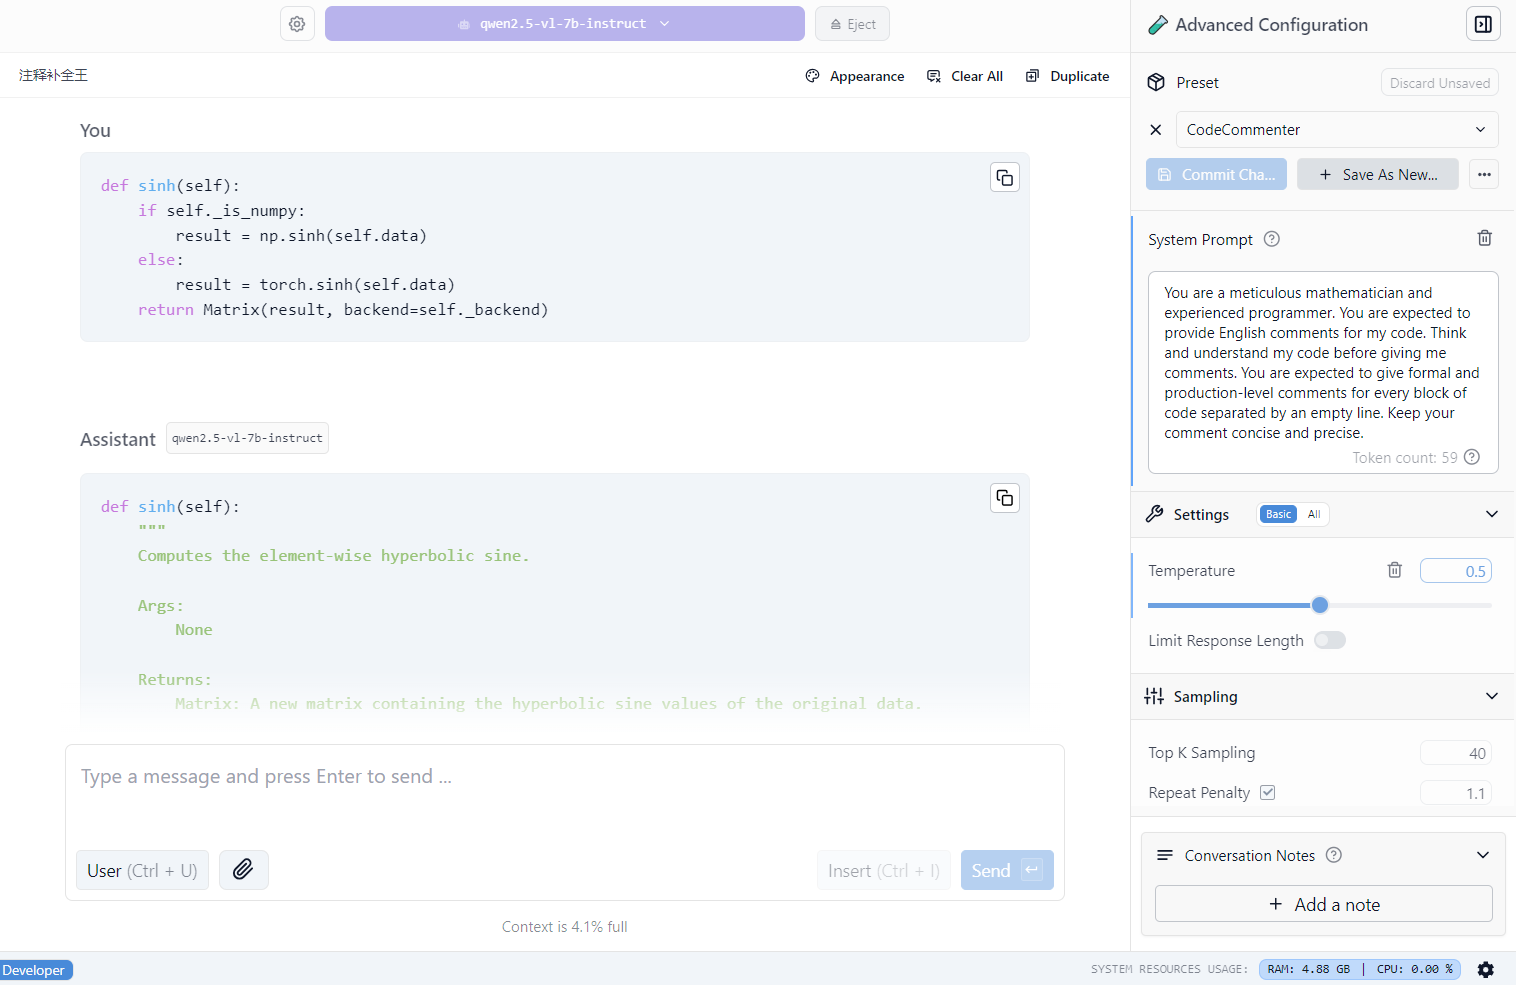

`1. CART Tree with Gini and Logloss with Capability of Tree Visualization (self-implemented)`

In [ ]:
# This CART tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class CART(BaseTree):
    
    __attr__ = "MML.CART"
    
    def __init__(self, task: str = 'regression', *,
                 tree_id: int = None,
                 loss: str = None,
                 max_depth: int = 12,
                 min_samples_split: float | int = 0.001,
                 grid_accelerator: int | None = 25,
                 grid_use_percentile: bool = False,
                 grid_point_variant: float | None = None,
                 prune: bool = True,
                 prune_alpha: float = 0.001,
                 random_state: int | None = None,
                 floattype: type = float,
                 feature_names: Matrix | Tensor | list | tuple | None = None):
        """
        Initialize a CART tree that can be used for regression or classification.

        Parameters:
            task: str, 'regression' or 'classification'.
            tree_id: int, the identifiation number for this tree. If None, then 0.
            loss: str, the name of the loss function applied.
                  For regression, choose 'mse' or 'rmse', or any RegressionMetrics;
                  For classification, 'gini' or 'logloss' may be used.
                  If not provided, defaults to 'mse' for regression and 'logloss' for classification.
            max_depth: int, Maximum depth of the tree.
            min_samples_split: float | int, when float, it is the minimum fraction required to split a node. Recommend [0.00, 0.02]
                               or when it is int, minimum number of samples.
            grid_accelerator: int | None, if non-None, use grid based splitor instead of exhaustive test. May lose accuracy. Minimum 10.
            grid_use_percentile: bool, if True, grid search will be based on percentiles, otherwise equally splited. Setting False is faster.
            grid_point_variant: float, if given, then points in the grid will be randomly move within this scale, Recommend [None, 0, 0.5]
            prune: bool, whether to prune the tree or not
            prune_alpha: float, L1 regularization on the number of leaves in the nested structure. Recommended values [0.00, 0.005]
            random_state: int, random seed for grid searching, controlling the fitting process, including the sequence of selecting features,
                          and the random movements applied on grid points, which is further controlled by grid_point_variant.
            floattype: type, The target float type that is going to be used in training
            feature_names: Matrix | Tensor, A 1D Matrix or Tensor of string names for features.
        """
        super().__init__(feature_names=feature_names)
        
        # Task and Loss Check
        self.tree_id = tree_id if tree_id is not None else 0
        self.task = task.lower()
        if self.task == 'regression':
            self.loss = loss if loss is not None else 'mse'
        elif self.task == 'classification':
            self.loss = loss if loss is not None else 'logloss'
        else:
            raise ValueError("Unsupported task. Choose 'regression' or 'classification'.")
            
        # Invalid grid accelerator
        if grid_accelerator is not None and grid_accelerator < 10:
            raise ValueError("Argument grid_accelerator should be an integer >= 10 to make the tree work properly. Or leave None to do an exahustive search.")
            
        # Regularization Related
        self.prune = prune
        self.prune_alpha = prune_alpha
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
        # Split Related 
        self.random_state = random_state
        self.grid_accelerator = grid_accelerator
        self.grid_percentile = grid_use_percentile
        self.grid_point_variant = grid_point_variant
        
        # Feature and Target info
        self.n_classes = None
        self.total_samples = None
        
        # Original Dataset (assigned in fit())
        self.original_X = None
        self.original_y = None
        self.floattype = floattype
        
        # Tree structure - a Dict of dict ...
        self.root = None # Tree object
        self.unpruned_root = None
                         # It is the core thing to see whether the tree is trained or not
        
        # Dictionary to keep track of total loss reduction per feature (for feature importance)
        self.feature_importance = {}
        
        # Record the type (Matrix or Tensor) of the input data for later reconstruction.
        self.typeclass = None
        
        # Record if it is one hot
        self.one_hot = None
        
        # Build a mapping from feature index to feature name.
        self.feature_index_map = {}
        
        # All features used in fit.
        self.use_features_idx = None
        
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, one_hot: bool = True, use_features_idx: list | None = None):
        """
        Fit the CART tree to the data.
        
        Parameters:
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            one_hot: bool, whether target y is one hot encoded
            use_features_idx, list of indices or None (all features)
        
        Returns:
            self
        """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Copy Training data
        self.original_X = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = self.floattype, device=y.device)
        
        # Record the one_hot case
        self.one_hot = one_hot
        
        # Record the input type.
        self.typeclass = type(X)
        
        # Get the number of classes
        self.n_classes = len(self._to_labels(y).flatten().unique())
        
        # Store total number of training samples to check against min_samples_split.
        self.total_samples = X.shape[0]
        
        # If feature names were provided, create a map for feature names
        self._create_feature_index_map()
        
        # Set features used
        self.use_features_idx = use_features_idx
        if self.use_features_idx is None:
            self.use_features_idx = list(range(X.shape[1]))
                
        # Build the tree recursively starting from the root.
        self.unpruned_root = self._build_tree(self.original_X, self.original_y, depth = 0)
        # Note, this _build_tree uses _find_best_split, which is desperately slow.
        # It may subject to future optimization using batched Tensor algebra.
        # By Nathmath Huang
        if self.prune == True:
            self.root = deepcopy(self.unpruned_root)
            self.root, _, _, _ = self._prune_tree(self.root, alpha = self.prune_alpha)
        else:
            self.root = deepcopy(self.unpruned_root)
            
        # Create feature importance mapping
        self._create_feature_importance(None, recursive=False)
            
        return self
    
    def _create_feature_index_map(self, *, regime: str = "Feature_{}"):
        """
        Creates a mapping from column indices to feature names or default names.
        
        Args:
            regime (str): A format string for generating default feature names if no names are provided.
                          Default is 'Feature_{index}'.
        
        Returns:
            self
        
        """
        # If feature names were provided, create a map from column index to feature name.
        # Otherwise, generate default names (e.g., "Feature0", "Feature1", ...)
        n_features = self.original_X.shape[1]
        if self.feature_names is not None:
            # If it is an Object
            if isinstance(self.feature_names, Object):
                feature_names = self.feature_names.flatten().to_list()
            # Or iterative containers
            else:
                feature_names = list(self.feature_names)
                
            # Map it from 0
            for i in range(n_features):
                self.feature_index_map[i] = feature_names[i]
        else:
            for i in range(n_features):
                self.feature_index_map[i] = regime.format(i)
        return self
    
    def _create_feature_importance(self, node = None, *, recursive: bool = False, use_prune: bool = True):
        """
        Creates a feature importance dict.
        
        Args:
            recursive: bool, if it is called by a recursive function or called externally.
            use_prune: bool, if using pruned tree or not.
        
        Returns:
            None
        
        """
        # Not recursive, first call, clear the self.feature_importance
        if recursive == False:
            self.feature_importance = {}
        
        # Not recursive, initially get the root
        if recursive == False and node is None:
            node = self.root if use_prune else self.unpruned_root
            
        # If the leaf node, return it
        if node.get("prediction", None) is not None:
            return
        
        # Feature improvement for feature importance.
        feat = node["feature_index"]
        self.feature_importance[feat] = self.feature_importance.get(feat, 0.0) + node["improvement"]
        
        # Recursively call left and right
        self._create_feature_importance(node["left"], recursive=True)
        self._create_feature_importance(node["right"], recursive=True)
        
        return
    
    def _build_tree(self, X: Matrix | Tensor, y: Matrix | Tensor, depth: int):
        """
        Recursively build the tree structure.
        
        Args:
            X: Matrix | Tensor, the splited data of features at this time.
            y: Matrix | Tensor, the splited target at this time.
        
        Returns:
            dict, A dictionary representing the node. Internal nodes have keys:
                'feature_index' and 'threshold' and pointers 'left' and 'right'.
            Leaf nodes have a key 'prediction' storing the constant prediction.
        """
        n_samples = X.shape[0]

        # Recursion Stops #####################################################
        # 
        # Determine if this node should be a leaf:
        # (1) Maximum depth reached, 
        # (2) too few samples to split, or 
        # (3) node is pure (no need to do further classification or regression)
        #  etc...
        if depth >= self.max_depth:
            return self._create_leaf(y)
            # Stopping critera 1)
        
        if n_samples < (self.min_samples_split if self.min_samples_split >= 1 else self.total_samples * self.min_samples_split):
            return self._create_leaf(y)
            # Stopping critera 2)
        
        if self._is_pure(y):
            return self._create_leaf(y)
            # Stopping critera 3)
        
        # Find the best split given the data at this node.
        if self.grid_accelerator is None:
            best_split = self._find_best_split(X, y)
        else:
            best_split = self._find_best_split_gridsearch(X, y, grid_k=self.grid_accelerator, percentile=self.grid_percentile)
        
        # If NO improvement or subset count == 0, still stop here.
        if best_split["improvement"].data <= 0 or best_split["left_count"] == 0 or best_split["right_count"] == 0:
            return self._create_leaf(y)
            # Stopping critera 4)
        
        # Partition the data into left and right children using the best split.
        left_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=True)
        right_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=False)
        
        # Use the masks to obtain subsets of the data.
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]
        
        #######################################################################
        # Recursive!
        #
        # Recursively build the left and right subtrees.
        left_node = self._build_tree(X_left, y_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, depth + 1)
        
        # Return the internal node as a dictionary.
        return {
            "feature_index": best_split["feature_index"],
            "threshold": best_split["threshold"],
            "improvement": best_split["improvement"],
            "weighted_loss": best_split["weighted_loss"],
            "left": left_node,
            "right": right_node
        }
    
    def _create_leaf(self, y: Matrix | Tensor, *, keepdims: bool = False):
        """
        Create a leaf node by computing the optimal constant prediction for the node.
        For regression, this is typically the mean; 
        For classification, it is the average distribution.
        
        Returns:
            dcit, dict of prediction
        """
        # For regression, we compute the arithmetic mean of y.
        # For classification, we compute the average of the one-hot outputs.
        # We STRONGLY recommend users to convert to one-hot data.
        if self.task == "regression":
            prediction = y.mean(axis=0)
        else:
            if self.one_hot == True:
                prediction = y.mean(axis=0)
            else:
                prediction = y.mean(axis=0)
        return {"prediction": prediction if keepdims == False else prediction.reshape([1, -1]).repeat(y.shape[0], axis=0)}    
    
    def _is_pure(self, y: Matrix | Tensor, *, std_thres: float = 1e-10):
        """
        Check whether the given target values are pure.
        For regression, this may check that the std devation is nearly zero (< std_thres).
        For classification, it may check whether all labels are identical.
        
        Returns:
            bool, whether the node is pure (perfectly classfied or regresed) or not.
        """
        if self.task == "regression":
            # Compute the std dev.
            stdev = y.std(axis=0)
            counts = self.typeclass(stdev.data <= 1e-8)
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True
        
        else:
            # For classification, if y is one-dimensional (integer labels), check if all are the same.
            # If one-hot, compare the argmax.
            if self.one_hot == True:
                labels = y.argmax(axis=1).flatten()
            else:
                labels = y.flatten()
            first = labels[0]
            counts = labels == first
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True

    def _find_best_split(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        This is the UN-optimized version using a O(n^2) nested loop.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """
        
        # Future Optimization:
        # > If note categorical data, you may use binary search instead of looping
        #   to find the optimal split within one feature.
        # > It will reduce O(n^2) to O(n * log(n))
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y)
        
        n_features = X.shape[1]
        
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float, parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.
            
            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.

            """
            
            # Obtain boolean masks for the split.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get the counts; if either side is empty, continue.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract left and right splits.
            y_left = y[mask_left.to_list()]
            y_right = y[mask_right.to_list()]
                
            # Compute predictions for left and right groups.
            left_pred = self._create_leaf(y_left, keepdims=True)["prediction"]
            right_pred = self._create_leaf(y_right, keepdims=True)["prediction"]
                
            # Compute losses using the external loss functions.
            left_loss = self._compute_loss(left_pred, y_left)
            right_loss = self._compute_loss(right_pred, y_right)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # Check if the improvement is the best so far.
            if improvement_.data > best_improvement.data:
                
                return {
                    "feature_index": i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}

        # Iterate over all features
        for i in range(n_features):
            
            # If the feature is NOT used, continue
            if i not in self.use_features_idx:
                continue
            
            # Get the entire column i as a Matrix/Tensor.
            feature_column = X[:, i]
            unique_values = feature_column.flatten().unique().sort().to_list()
            
            # Skip if there is only one unique value.
            if len(unique_values) <= 1:
                continue
            
            # Consider candidate thresholds between adjacent unique values.
            for j in range(len(unique_values) - 1):
                
                # Use the midpoint as candidate threshold.
                threshold_candidate = (unique_values[j] + unique_values[j + 1]) / 2
               
                # Conduct a test on this 
                _test_result = _test_feature_threshold(i, threshold_candidate, parent_loss, best_improvement=best_split["improvement"])
                    
                if len(_test_result) > 0:
                    best_split = _test_result
                
        return best_split
    
    def _find_best_split_gridsearch(self, X: Matrix | Tensor, y: Matrix | Tensor, 
                                    *, grid_k: int = 50, random_state:int | None = None,
                                    variant: float | None = None, percentile: bool = False):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        Uses a combination of grid search (with progressive interval refinement)
        to efficiently explore the candidate threshold space.
        
        Args:
            grid_k: int, the number of grid points within a specific range, default is 50, recommend 20, 50, 100, 200.
            random_state: int, the random seed controlling the sequence of inspecting features and grid variants, if None, then randomly draw.
            variant: float, the size (in decimal) of random noise to add on the splited grid points, if None, then add nothing.
            percentile: bool, whether to use fix grid points or computed percentile values (as the base) to check the thresholds.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """        
        # Set the global seed if passed
        if random_state is not None:
            random.seed(random_state)
            random_state += 2597 # Offset to make it be reusable
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y)
        
        n_features = X.shape[1]
        
        # Randomly choose the sequence of features (including non-used, but anyway, we will prevent using them)
        seq_features = list(range(n_features))
        random.shuffle(seq_features)
        
        #######################################################################
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float,
                                    parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.

            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.
            
            """
            
            # Obtain boolean masks.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get counts; if either side is empty, skip.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract splits.
            y_left = y[mask_left.to_numpy_array()]
            y_right = y[mask_right.to_numpy_array()]
                
            # Compute predictions.
            left_pred = self._create_leaf(y_left, keepdims=True)["prediction"]
            right_pred = self._create_leaf(y_right, keepdims=True)["prediction"]
                
            # Compute losses.
            left_loss = self._compute_loss(left_pred, y_left)
            right_loss = self._compute_loss(right_pred, y_right)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # If this candidate beats the current best, return its details.
            if improvement_.data > best_improvement.data:
                return {
                    "feature_index": feature_i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}
        
        #######################################################################
        # Grid search accelerator
        def _grid_search_threshold(feature_i: int, unique_values: list,
                                   X: Matrix | Tensor, y: Matrix | Tensor, 
                                   parent_loss_: float, best_improvement: Matrix | Tensor,
                                   grid_k: int = 50, tol_points: int | None = None, 
                                   random_state: int | None = None, variant:float | None = None, percentile: bool = True) -> dict:
            """
            Perform a multi-resolution grid search within the range spanned by unique_values.
            - First, sample grid_k thresholds (linearly across [min, max]).
            - Find the grid candidate with the best improvement.
            - If the candidate is not on the boundary, narrow the interval to the neighbors of this candidate.
            - When the number of unique values inside the refined interval is below tol_points,
              fall back to exhaustive search on those unique values.
              
            Returns the best candidate for this feature as a dict.
            """
            # Grid k minimum 10, to make the searching algorithm works
            if grid_k is None:
                grid_k = 50
            elif grid_k < 10:
                grid_k = 10
            
            # If tol_points not initialized
            if tol_points is None:
                tol_points = int(grid_k * 1.5)
            
            low = unique_values[0]
            high = unique_values[-1]
            candidate = {}
            
            # If unique values is smaller than tol_points
            if len(unique_values) < tol_points:
                
                # Perform exhaustive search on these.
                for it, th in enumerate(unique_values):
                    if it == 0:
                        continue
                    thres = (unique_values[it-1] + unique_values[it]) / 2
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_improvement)
                    if len(res) > 0:
                        candidate = res
                        best_improvement = res["improvement"]
                return candidate                    
            
            # Percentile helper
            def _percentile_within(data, percentiles: list, lower_threshold: float, upper_threshold: float):
                """
                Computes specified percentile values for data within a given threshold range.
            
                Parameters:
                    data (np.ndarray): Input 1D data array.
                    percentiles (np.ndarray or list): Percentiles to compute, e.g., [25, 50, 75].
                    lower_threshold (float): Lower bound of the data to include.
                    upper_threshold (float): Upper bound of the data to include.
            
                Returns:
                    np.ndarray: Computed percentile values of the filtered data.
                """
                if not isinstance(data, np.ndarray):
                    data = np.array(data)
            
                filtered_data = data[(data >= lower_threshold) & (data <= upper_threshold)]
                
                if filtered_data.size == 0:
                    return np.array([]) # Empty, error happened
            
                return np.percentile(filtered_data, percentiles)
            
            # Initialize the random machine
            if random_state is not None:
                np.random.seed(random_state)
            
            # If variant is too large (> 0.5), then make as 0.5
            if variant is not None:
                variant = 0.5 if variant > 0.5 else variant
            
            # Percentiles we have
            percentiles = np.arange(0.0, 100 + 1e-10, 100.0 / grid_k)

            while True:
                # Create grid points between low and high.
                if percentile == False:
                    grid_points = [low + (high - low) * i / (grid_k - 1) for i in range(grid_k)]
                else:
                    grid_points = list(_percentile_within(unique_values, percentiles, low, high))
                    if len(grid_points) == 0:
                        break
                
                # If add random noise as variance
                if variant is not None:
                    def diff_stdev(x):
                        diff_values = np.diff(x)
                        result = np.insert(diff_values, 0, 0)
                        return result.std()
                    grid_points_len = len(grid_points)
                    grid_diff_stdev = diff_stdev(grid_points)
                    grid_points = (np.array(grid_points) + np.random.randn(grid_points_len) * variant * grid_diff_stdev).tolist()
                
                best_local = {}
                
                # Starting benchmark
                best_local_improvement = best_improvement
                
                # Test each candidate in the grid.
                for thres in grid_points:
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_local_improvement)
                    if len(res) > 0:
                        best_local = res
                        best_local_improvement = res["improvement"]
                
                # If no candidate was found in this grid, exit.
                if len(best_local) == 0:
                    break
                
                # Find the index of the best candidate in grid_points.
                idx = grid_points.index(best_local["threshold"])
                
                # If at boundary, use single side refinement
                if idx == 0 or idx == len(grid_points) - 1:
                    if idx == 0:
                        new_low = grid_points[idx]
                        new_high = grid_points[idx + 1]
                    else:
                        new_low = grid_points[idx - 1]
                        new_high = grid_points[idx]
                else:
                    # Define new search boundaries as the adjacent grid points.
                    new_low = grid_points[idx - 1]
                    new_high = grid_points[idx + 1]
                    
                # Count how many unique values lie within the new interval.
                interval_points = [v for v in unique_values if new_low <= v <= new_high]
                
                # If the interval is sufficiently resolved, perform exhaustive search on these.
                if len(interval_points) < tol_points:
                    best_exhaustive = {}
                    best_ex_improvement = best_local_improvement
                    for it, th in enumerate(interval_points):
                        if it == 0:
                            continue
                        thres = (interval_points[it-1] + interval_points[it]) / 2
                        res = _test_feature_threshold(feature_i, thres, parent_loss_, best_ex_improvement)
                        if len(res) > 0:
                            best_exhaustive = res
                            best_ex_improvement = res["improvement"]
                    candidate = best_exhaustive if len(best_exhaustive) > 0 else best_local
                    break
                else:
                    # Update the boundaries and repeat.
                    low, high = new_low, new_high
                    candidate = best_local
                    
            return candidate

        # Iterate over features.
        for i, feat in enumerate(seq_features):
            
            # If the feature is NOT used, continue
            if feat not in self.use_features_idx:
                continue
            
            # Get sorted unique values for feature feat.
            feature_column = X[:, feat]
            unique_values = feature_column.flatten().unique().sort().to_list()
            if len(unique_values) <= 1:
                continue
            
            # Run grid search on this feature.
            candidate = _grid_search_threshold(feat, unique_values, X, y, parent_loss, best_split["improvement"], 
                                               grid_k=grid_k, 
                                               random_state=random_state,
                                               variant=variant,
                                               percentile=percentile)
            
            # Update best_split if this candidate is better.
            if len(candidate) > 0 and candidate["improvement"].data > best_split["improvement"].data:
                best_split = candidate
                
        return best_split
    
    def _get_mask(self, X: Matrix | Tensor, feature_index: int, threshold: float, *, left=True):
        """
        Return a boolean mask for the rows of X based on the threshold at the given feature index.
        
        Parameters:
            left: if True, returns mask for rows where X[:, feature_index] <= threshold;
                  otherwise, returns mask for rows where X[:, feature_index] > threshold.
        
        Args:
            Matrix | Tensor, with boolean indicating whether smaller or greater than the threshold.
        """
        if left:
            return self.typeclass(X[:, feature_index].data <= threshold, backend=X._backend, dtype=bool, device=X.device)
        else:
            return self.typeclass(X[:, feature_index].data > threshold, backend=X._backend, dtype=bool, device=X.device)
    
    def _compute_loss(self, prediction: Matrix | Tensor, y: Matrix | Tensor):
        """
        Compute the loss between the prediction (a constant for a node) and the true target y.
        Dispatch to the corresponding external function.
        
        Returns:
            Matrix | Tensor, even if the metrics is a scalar.
        """        
        if self.task == "regression":
            metrics = RegressionMetrics(prediction, y, metric_type = self.loss)
            return metrics.compute()
        else:
            # If gini, then we use the built-in gini
            if self.loss == 'gini':
                return self._gini_impurity(y, one_hot = self.one_hot)
            else:
                if self.n_classes > 2:
                    metrics = MultiClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype)
                else:
                    metrics = BinaryClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype)
                    
    def _prune_tree(self, node=None, X=None, y=None, *, alpha: float = 0.001):
        """
        Recursively prune the tree using cost-complexity pruning.
        At each node, we compare:
        
            cost_if_pruned = (n_samples * avg_loss_at_node) + alpha * 1
            subtree_cost = (cost from left subtree + cost from right subtree)
        
        The loss is assumed to be an average per sample, so we multiply by the number
        of samples in that node (n). For leaves, the cost is computed as:
        
            leaf_cost = n * (avg loss at that leaf) + alpha
        
        Parameters:
            node: Dict, The current subtree (as a dict). If None, uses self.root.
            X: Matrix | Tensor, The subset of features (a Matrix or Tensor) for samples that reached this node.
               If None, uses self.original_X (the entire training set).
            y: Matrix | Tensor, The corresponding targets for the samples in X.
               If None, uses self.oroginal_y.
            alpha: float, The complexity parameter to penalize the number of leaves.
        
        Returns:
            A tuple (pruned_node, cost,  n_samples, num_leaves), where:
                pruned_node: the (possibly pruned) subtree.
                cost: the total cost = loss + ccp_alpha * (number of leaves) for this subtree.
                n_samples: total samples at this node
                num_leaves: the total number of leaves in the pruned subtree.
        """
        # On the first call, set node to root and X, y to the original training set.
        if node is None:
            node = self.root
        if X is None:
            X = self.original_X
        if y is None:
            y = self.original_y
            
        # number of samples in current node
        n = X.shape[0]
        
        # loss scaling factor
        scaling_factor = 1 / self.total_samples

        # If the node is a leaf, compute its cost.
        if "prediction" in node:
            # For a leaf node, compute loss on the training samples that reached this leaf.
            leaf_pred = node["prediction"]
            loss_leaf = self._compute_loss(leaf_pred.reshape([1,-1]).repeat(y.shape[0], axis=0), y)
            return node, scaling_factor * n * loss_leaf + alpha * 1, n, 1

        # Otherwise, the node is internal.
        # Retrieve the splitting criterion stored in the node.
        feat_idx = node["feature_index"]
        thresh = node["threshold"]

        # Obtain the boolean masks for splitting X into left and right subsets.
        left_mask = self._get_mask(X, feat_idx, thresh, left=True)
        right_mask = self._get_mask(X, feat_idx, thresh, left=False)

        # Use the mask to partition the data. (This uses vectorized slicing, so there is no Python loop.)
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]

        # Recursively prune the left and right subtrees.
        pruned_left, cost_left, n_left, leaves_left = self._prune_tree(node["left"], X_left, y_left, alpha=alpha)
        pruned_right, cost_right, n_right, leaves_right = self._prune_tree(node["right"], X_right, y_right, alpha=alpha)

        # Combine the cost for the subtree as currently structured.
        subtree_cost = cost_left + cost_right
        subtree_leaves = leaves_left + leaves_right

        # Now compute the cost if we were to prune (collapse) this internal node into a single leaf.
        # Use all samples that reach the current node (X, y) to compute the aggregated prediction.
        pruned_leaf = self._create_leaf(y, keepdims = False)
        # returns a dict with key "prediction"
        loss_pruned = self._compute_loss(pruned_leaf["prediction"].reshape([1,-1]).repeat(y.shape[0], axis=0), y)
        pruned_cost = scaling_factor * n * loss_pruned + alpha * 1  # complexity: one leaf

        # Decide whether to prune this node.
        # > pruned_cost: use this node as a leaf, the cost computed
        # > subtree_cost: use the original nested structure, the cost computed
        if pruned_cost.data <= subtree_cost.data:
            # Prune it and set this as the leaf
            return pruned_leaf, pruned_cost, n, 1
        else:
            # Otherwise, update this node with the subtrees.
            node["left"] = pruned_left
            node["right"] = pruned_right
            node["pruned_cost"] = subtree_cost
            node["num_leaves"] = subtree_leaves
            return node, subtree_cost, n, subtree_leaves
                
    def predict(self, X: Matrix | Tensor):
        """
        Predict target values for samples in X.
        
        Returns:
            Matrix | Tensor, output of predictions.
        """
        if not self.root:
            raise TypeError("Please train the tree first.")
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
        
        # Create a float typed X
        X_float = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        
        # Create a container for predictions with the same number of samples as X.
        predictions = self.typeclass.zeros_like(self.original_y[0], backend = X._backend, dtype = float).reshape([1, -1]).repeat(X.shape[0], axis=0)
        
        # Predict recursively.
        self._predict_recursive(X_float, self.root, predictions, indices=self.typeclass(list(range(X.shape[0])), backend=X._backend))
        
        return predictions

    def _predict_recursive(self, X: Matrix | Tensor, node: dict, predictions: list, indices: Matrix | Tensor):
        """
        Recursively traverse the tree: at each node, assign predictions to the corresponding indices.
        
        Parameters:
            X: Feature matrix for all samples.
            node: The current node (dictionary). If a leaf, 'prediction' key exists.
            predictions: A preallocated Matrix or Tensor object to store predictions.
            indices: Indices (or a mask) of rows in X that fall into this node.
            
        Returns: 
            None   
        
        """
        # If the node is a leaf, assign the leaf's prediction to all indices.
        if "prediction" in node:
            if len(indices) > 0:
                predictions[indices.to_numpy_array()] = node["prediction"]
            return
        
        # If no indices, return 
        if len(indices) == 0:
            return
        
        # Get the splitting criteria.
        feature_index = node["feature_index"]
        threshold = node["threshold"]
        
        X_subset = X[indices.to_list()]
        left_mask = self._get_mask(X_subset, feature_index, threshold, left=True)
        right_mask = self._get_mask(X_subset, feature_index, threshold, left=False)
        
        # Convert the boolean masks to index Matrix | Tensors
        left_indices = indices[self.typeclass.where(left_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        right_indices = indices[self.typeclass.where(right_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        
        # Recurse on the left and right children.
        self._predict_recursive(X, node["left"], predictions, left_indices)
        self._predict_recursive(X, node["right"], predictions, right_indices)
    
    def plot_tree(self, figsize = (14, 8)):
        """
        Plot an image representing the structure of the decision tree.
        
        This function traverses the tree recursively, assigns (x,y) positions to each node,
        and then uses matplotlib to render the tree structure. For internal nodes, the label
        is in the form "Feature <= threshold" (with threshold rounded to 4 digits).
        
        For leaf nodes, the label shows the prediction.
        
        Args:
            figsize: tuple, the size of the plot
        """
        if self.root is None:
            raise ValueError("Tree has not been built yet. Please fit the tree first.")

        # Dictionaries to store node positions and labels, and a list for edges.
        node_positions = {}
        node_labels = {}
        edges = []
        
        # Mutable counters to keep track of node id and horizontal position.
        counter = [0]        # For node IDs.
        current_x = [0]      # For assigning x-coordinate in an in-order fashion.

        def assign_positions(node, depth):
            """
            Recursively assign positions to each node.
            
            Returns:
                A tuple of (x_position, node_id) for the current node.
            """
            my_id = counter[0]
            counter[0] += 1

            # If leaf node, assign current x position and label using prediction.
            if "prediction" in node:
                pos = (current_x[0], -depth)
                node_positions[my_id] = pos
                # Extract prediction; if it is a Matrix/Tensor, extract its scalar list.
                pred = node["prediction"]
                if hasattr(pred, "to_list"):
                    pred = pred.to_list()
                # Format prediction as a rounded list (if list) or scalar.
                def force_round(num, n=4):
                    return f"{num:.{n}f}"
                if isinstance(pred, list):
                    pred_str = ",\n ".join(str(force_round(x, 4)) for x in pred) + ","
                else:
                    pred_str = str(round(pred, 4))
                node_labels[my_id] = pred_str
                current_x[0] += 1
                return node_positions[my_id], my_id

            # Else, process an internal node.
            else:
                # Recursively assign position to the left subtree.
                left_pos, left_id = assign_positions(node["left"], depth + 1)
                # Reserve current node id for the internal node.
                current_node_id = my_id
                # Recursively assign position to the right subtree.
                right_pos, right_id = assign_positions(node["right"], depth + 1)
                # Set current node's x position as the average of its children's x positions.
                x = (node_positions[left_id][0] + node_positions[right_id][0]) / 2
                pos = (x, -depth)
                node_positions[current_node_id] = pos

                # Format the internal node label using the feature name and threshold.
                feature_name = self.feature_index_map.get(node["feature_index"], f"F{node['feature_index']}")
                thresh_val = node["threshold"]
                if hasattr(thresh_val, "to_list"):
                    thresh_val = thresh_val.to_list()
                    if isinstance(thresh_val, list):
                        thresh_val = thresh_val[0] if len(thresh_val) == 1 else thresh_val
                node_labels[current_node_id] = f"{feature_name} <= {round(thresh_val, 4)}"
                # Record edges from the current node to its left and right children.
                edges.append((current_node_id, left_id))
                edges.append((current_node_id, right_id))
                return pos, current_node_id

        # Build node positions and labels from the tree starting at the root at depth 0.
        _, root_id = assign_positions(self.root, depth=0)

        # Create the plot.
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each edge.
        for parent, child in edges:
            x_vals = [node_positions[parent][0], node_positions[child][0]]
            y_vals = [node_positions[parent][1], node_positions[child][1]]
            ax.plot(x_vals, y_vals, 'k-', lw=1)
        # Plot the nodes with their labels.
        for node_id, (x, y) in node_positions.items():
            ax.text(x, y, node_labels[node_id], ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.set_title(f"CART Tree (ID: {self.tree_id})")
        ax.axis('off')
        plt.show()

    def plot_feature_importance(self, features: int = None, figsize=(8, 5)):
        """
        Plot an image of the feature importance as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        
        Args:
            features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot
        """
    
        if not self.feature_importance:
            print("No feature importance data available. Please train the tree first.")
            return
    
        # Extract feature indexes and corresponding importance values as scalars.
        feat_imp_list = []
        for feat_idx, imp in self.feature_importance.items():
            # Get feature name from feature_index_map.
            feature_name = self.feature_index_map.get(feat_idx, f"Feature_{feat_idx}")
            val = imp.to_list()  # extract raw value(s)
            if isinstance(val, list):
                val = val[0] if len(val) == 1 else val
            feat_imp_list.append((feature_name, round(val, 4)))
        
        # Sort the features by importance descending (largest first).
        feat_imp_list.sort(key=lambda x: x[1], reverse=True)
        
        # Truncate if employed
        if features is not None:
            feat_imp_list = feat_imp_list[0:features]
        
        # Unzip the sorted feature names and importance values.
        features, importances = zip(*feat_imp_list)
        
        # Create a bar chart with the sorted feature importances.
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(features, importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_title("Feature Importance (Gain)")
        
        # Add text labels on top of the bars.
        for idx, v in enumerate(importances):
            ax.text(idx, v, str(v), ha='center', va='bottom')
        plt.show()

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: CART, a cart object
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : "MML.CART", "data": instance}, filepath, kompress=lzma, protocol=5)
        
    @staticmethod
    def load(filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            filepath: str, the destination file path to save.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError("The file input is NOT a valid CART model.")
        if rawobj.get("__attr__", "") != "MML.CART":
            raise ValueError("The file input is NOT a valid CART model.")
        return rawobj["data"]

    def __repr__(self):
        return f"CART(task = {self.task}, loss = {self.loss}, n_features = {self.n_classes})."

# !!!
# Functionality Introduction
# > 1. Initializing a tree: call model = CART(...), you must at least specify the task "classification"
#      or "regression". Fine-tuning a proper loss and other hyperparameters is recommended.
# > 2. Fitting a tree: call model.fit(...), passing the feature Matrix | Tensor X and target Matrix | Tensor y, 
#      which can be either a classification problem or a regression problem.
# > 3. Predicting data: call model.predict(...) with new feature Matrix | Tensor. It will return the result
#      that is the same as the training target (one-hot or multi-label) in the same wrapper Matrix | Tensor.
# > 4. Plotting the tree structure: call model.plot_tree(...) to get an image of the tree structure with 
#      nodes and leaves, indicating the rules used by this tree model to do this task.
# > 5. Plotting feature importance chart: call model.plot_feature_importance(...) to get a plot of the most k
#      important features in a importance-decreasing bar chart (like the xgboost one, but is vertically plotted).
# > 6. Save and load models: call CART.save(...) to save, CART.load(...) to load. I have tried some times and did not
#      find any incompatibility when it comes up with numpy backend and torch backend.

# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Gini impurity and information gain criteria
# ---> Gini impurity is implemented in the `BaseTree` class, which calculates the gini 
# ---> loss by considering the chaos of classes within a subset of data.
# ---> It accepts binary and multiple classification cases as well as one-hot encoding.
# ---> Information gain is embedded in the implementation of `CART` tree. 
# ---> Information gain is the difference between the loss of unsplitted subset and the loss
# ---> of splited subsets, which can be seen in the `_find_best_split` method and its optimized
# ---> variant `_find_best_split_gridsearch`.
#
# > Handling both categorical and numerical features
# ---> For numerical features, they are naturally good since the CART tree uses a numerical 
# ---> threshold every time to decide a split point.
# ---> For categorical features, I have designed and implemented a `CategoricalEncoder` class
# ---> which can handle categorical features stored in a pd.DataFrame. They can be one-hot encoded
# ---> or encoded into multiple numbers (like 0, 1, 2, 3, ...) representing the grades or quality.
# ---> In this specific case, I will use both ways to handle different features with varied nature.
#
# > Recursive tree construction
# ---> I designed the class CART to use recursive methods to construct the binomial tree from its root node.
# ---> The `_build_tree` method call itself twice each time to attempt to create a left branch and right branch
# ---> until one of the regularization constraint meets or the data remained is already `pure`.
# ---> The `purity` I defined is that all samples remained belong to the same class, or identically the same
# ---> as the target (for regression tasks).
# ---> For data structure, the tree is represented by a deeply nested `dict` object, storing all information needed
# ---> with some of numerical data stored in Matrix and Tensor instances.
#
# > Pruning the tree, with depth and minimum split size constraints
# ---> Overall, CART tree is implemented 2 build-time regularization: Max Depth and Min Split Size,
# ---> as well as a post-build regularization: Pruning using L1 regularization of number of leaves.
# ---> Depth and Minimum Split are initialized in `__init__`, while used in `_build_tree` method.
# ---> They, in fact, decide whether a tree has to come to an end of leaf nodes in a forward manner while
# ---> recursively building the tree.
# ---> Pruning happens when the tree is built up. Optionally, if the `prune` parameter is set to True,
# ---> the algorithm will recursively calculate the `pruning loss` while having penalty on the complexty of 
# ---> the tree, measured by some constants times the number of leaves in the sub-structure of one specific node.
# ---> I have observed strongly positive evidence showing pruning the tree gives better generalization.

# !!!
# Some Optimization I implemented to speed up
# > Since the traditional method introduced in class, testing the midpoint of every single two consecutive samples 
# ---> that are sorted is generally in O(n^2) complexity. It becomes unacceptably slow when it comes to thousands of 
# ---> samples when it was trained on.
# ---> I researched and designed a `grid_search` method that can select random / importance based points within
# ---> the range of that feature, getting rid of the process to iterate all `n` samples, but creates a grid, find
# ---> the best grid, and then create a sub-grid within the suspacious area. It generally reduce the complexity to
# ---> O(nlog(n)) level, which is also slow, but is faster compared to the UN-optimized version.
# > To use this optimization, please at least set `grid_accelerator` into an integer value representing the number of 
# ---> grids tested each time. Note, a bigger `grid_accelerator` is NOT always beneficial.
# ---> Moreover, you may try `grid_percentile = True` to enable importance sampling, which is slightly slower but generally
# ---> produces a better grid result since it focus on the dense area in stead of simply uniformly investigating.
# > For more optimization, please see the source code. I have well commented everything I did. 

`2.1 Load Data into the Notebook Environment and Process the Categorical Features`

In [29]:
# Load the provided car dataset
#

# Define the URL.
car_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/car.data.csv'

# Load the car dataset into a pandas DataFrame.
raw_car = pd.read_csv(car_url)
raw_car

,Buying,Maint,Doors,Persons,LugBoot,Safety,Target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [65]:
# Inspect each non-numerical feature and transform them.
processed_car = raw_car.copy()

# Feature `Buying` - there are ['vhigh', 'high', 'med', 'low']
_ = processed_car["Buying"].unique()
# Create a mapping function assigning low < med < high < vhigh
def _mapping_buying(x) -> bool:
    _vmp = {
     "vhigh": 3,
     "high": 2,
     "med": 1,
     "low": 0}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_buying = CategoricalEncoder(["Buying"], mode = "multi", sort_func = _mapping_buying, pad_value=0)
processed_car = cate_encoder_buying.fit_transform(processed_car)

# Feature `Maint` - there are ['vhigh', 'high', 'med', 'low']
_ = processed_car["Maint"].unique()
# Let's use the same logic to create a mapping
def _mapping_maint(x) -> bool:
    _vmp = {
     "vhigh": 3,
     "high": 2,
     "med": 1,
     "low": 0}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_maint = CategoricalEncoder(["Maint"], mode = "multi", sort_func = _mapping_maint, pad_value=0)
processed_car = cate_encoder_maint.fit_transform(processed_car)

# Feature `Doors` - there are ['2', '3', '4', '5more']
_ = processed_car["Doors"].unique()
# Let's use the same logic to create a mapping
def _mapping_doors(x) -> bool:
    _vmp = {
     "5more": 5,
     "4": 4,
     "3": 3,
     "2": 2}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_doors = CategoricalEncoder(["Doors"], mode = "multi", sort_func = _mapping_doors, pad_value=0)
processed_car = cate_encoder_doors.fit_transform(processed_car)

# Feature `Persons` - there are ['2', '4', 'more']
_ = processed_car["Persons"].unique()
# Let's use the same logic to create a mapping
def _mapping_persons(x) -> bool:
    _vmp = {
     "more": 5, 
     "4": 4,
     "2": 2}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_persons = CategoricalEncoder(["Persons"], mode = "multi", sort_func = _mapping_persons, pad_value=0)
processed_car = cate_encoder_persons.fit_transform(processed_car)

# Feature `LugBoot` - there are ['small', 'med', 'big']
_ = processed_car["LugBoot"].unique()
# Let's use the same logic to create a mapping
def _mapping_lugboot(x) -> bool:
    _vmp = {
     "big": 3, 
     "med": 2,
     "small": 1}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_lugboot = CategoricalEncoder(["LugBoot"], mode = "multi", sort_func = _mapping_lugboot, pad_value=0)
processed_car = cate_encoder_lugboot.fit_transform(processed_car)

# Feature `Safety` - there are ['low', 'med', 'high']
_ = processed_car["Safety"].unique()
# Let's use the same logic to create a mapping
def _mapping_safety(x) -> bool:
    _vmp = {
     "high": 3, 
     "med": 2,
     "low": 1}
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder_safety = CategoricalEncoder(["Safety"], mode = "multi", sort_func = _mapping_safety, pad_value=0)
processed_car = cate_encoder_safety.fit_transform(processed_car)

# Target - there are ['unacc', 'acc', 'vgood', 'good']
_ = processed_car["Target"].unique()
# Let's use the same logic to create a mapping
def _mapping_target(x) -> bool:
    _vmp = {
     "vgood": 4,
     "good": 3, 
     "acc": 2,
     "unacc": 1}
    return _vmp[str(x)], str(x)
# Create a Encoder ! Note, by one-hot mode, since we want to use Gini and Crossentropy
cate_encoder_target = CategoricalEncoder(["Target"], mode = "onehot", sort_func = _mapping_target, pad_value=0)
processed_car = cate_encoder_target.fit_transform(processed_car)

# This is the complete dataset
processed_car

,Buying,Maint,Doors,Persons,LugBoot,Safety,Target_unacc,Target_acc,Target_good,Target_vgood
0,3,3,0,0,0,0,1,0,0,0
1,3,3,0,0,0,1,1,0,0,0
2,3,3,0,0,0,2,1,0,0,0
3,3,3,0,0,1,0,1,0,0,0
4,3,3,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1723,0,0,3,2,1,1,0,0,1,0
1724,0,0,3,2,1,2,0,0,0,1
1725,0,0,3,2,2,0,1,0,0,0
1726,0,0,3,2,2,1,0,0,1,0


In [88]:
# Astype into float32.
merged_car = processed_car.copy().astype("float32")
merged_car

# Create the Features Matrix
features_car = Matrix(merged_car[["Buying", "Maint", "Doors", "Persons", "LugBoot", "Safety"]], backend=backend, device=device)
print(features_car)

# Create the Targets Matrix
targets_car = Matrix(merged_car[["Target_unacc", "Target_acc", "Target_good", "Target_vgood"]], backend=backend, device=device)
print(targets_car)

# Create a feature name list
feature_names = ["Buying", "Maint", "Doors", "Persons", "LugBoot", "Safety"]

Matrix(backend=numpy, shape=(1728, 6), data=
[[3. 3. 0. 0. 0. 0.]
 [3. 3. 0. 0. 0. 1.]
 [3. 3. 0. 0. 0. 2.]
 ...
 [0. 0. 3. 2. 2. 0.]
 [0. 0. 3. 2. 2. 1.]
 [0. 0. 3. 2. 2. 2.]])
Matrix(backend=numpy, shape=(1728, 4), data=
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]])


`2.2 Split the dataset into 80% training and 20% test`

In [72]:
# Split the data into training (80%) and test (20%) sets
# 

# The balanced train_test_split is implemented in the MLBase class.
train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
    features_car, targets_car, test_size=0.2, random_state=2821)
train_feature, test_feature,

(Matrix(backend=numpy, shape=(1382, 6), data=
 [[1. 3. 1. 1. 1. 1.]
  [1. 2. 1. 0. 1. 1.]
  [1. 1. 0. 1. 2. 1.]
  ...
  [0. 2. 1. 1. 0. 1.]
  [3. 1. 1. 2. 1. 1.]
  [1. 3. 3. 2. 2. 1.]]),
 Matrix(backend=numpy, shape=(346, 6), data=
 [[2. 1. 2. 0. 2. 2.]
  [0. 1. 1. 0. 0. 0.]
  [2. 3. 0. 2. 0. 2.]
  ...
  [1. 1. 3. 2. 0. 0.]
  [1. 2. 2. 1. 1. 1.]
  [3. 2. 2. 1. 1. 1.]]))

In [ ]:
# Let's see if the classes in train-test sets are balanced or not
#

print("Train set: ", train_target.sum(axis=0), "\nTest set:  ", test_target.sum(axis=0))
# Well, Okay. Acceptable. 
# Since all of those features are categorical, it's hard to generate synthetic samples.
# So, that's it.

Train set:  Matrix(backend=numpy, shape=(4,), data=
[976. 300.  52.  54.]) 
Test set:   Matrix(backend=numpy, shape=(4,), data=
[234.  84.  17.  11.])


`2.3, 2.4 Train and Evaluate pipeline`

In [116]:
# A batch pipeline on doing this TREE classification task
# 

def tree_batch_classification(train_feature, test_feature, train_target, test_target, num_classes,
                              use=["my", "sklearn"], *,
                              verbosity = 0, plot_tree = True, plot_feature_importance = True,
                              max_depth = 8, loss = "gini", min_samples_split = 10, **kwargs):
    
    """
    Trains and evaluates a Decision Tree (CART) model using either my custom implementation or sklearn.

    Args:
        train_feature (Matrix | Tensor): Training feature data.
        test_feature (Matrix | Tensor): Test feature data.
        train_target (Matrix | Tensor): Training target labels.
        test_target (Matrix | Tensor): Test target labels.
        num_classes (int): Number of classes to be classified.
        use: List of strings indicating the classification method to use. 
             Should be one of ["my", "sklearn"].
        verbosity (int): Whether to print some progresses if set to non-zero values.
        plot_tree (bool): Whether to plot the tree structure or not, only valid when using "my".
        plot_feature_importance (bool): Whether to plot the feature importance chart or not, only valid when using "my".
        max_depth (int): Maximum depth of the unpruned tree structure, can be integers.
        loss (str): Name of loss function applied, can be "gini", "logloss" or "log_loss".
        min_samples_split (float | int): A minimum fraction or number of samples to be in one leaf.
        **kwargs: Any other arguments, will be set to CART() and DecisionTreeClassifier() initialization.

    Returns:
        tuple: A tuple containing accuracy, precision, recall, F1-score, AUC, and confusion matrix. ROC curve is only plotted when using "my" mode.

    Raises:
        ValueError: If `use` argument is neither "my" nor "sklearn".

    """

    # Returns a tuple of (Model, Accuracy, Confusion Matrix (in Matrix | Tensor), and Logloss)
    
    if isinstance(use, list):
        use = use[0]
    if use != "my" and use != "sklearn":
        return ValueError("Arg `use` must be either `my` or `sklearn`!")
    
    # If using sklearn, forcefully convert data into numpy backend and scale it
    if use == "sklearn":
        from sklearn.tree import DecisionTreeClassifier
        train_feature = train_feature.to("numpy")
        train_target = train_target.to("numpy")
        test_feature = test_feature.to("numpy")
        test_target = test_target.to("numpy")
    else:
        pass

    # Create a CART instance before doing everything.
    if use == "my":
        if verbosity >= 1:
            print("Using CART as the classifier ...")
        model = CART("classification", loss = loss if loss != "log_loss" else "logloss", max_depth = max_depth, min_samples_split = min_samples_split, **kwargs)
    else:
        if verbosity >= 1:
            print("Using sklearn's DecisionTreeClassifier as the classifier ...")
        model = DecisionTreeClassifier(criterion = loss if loss != "logloss" else "log_loss", max_depth = max_depth, min_samples_split = min_samples_split, **kwargs)

    # Fit the model with the training dataset
    if use == "my":
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature, train_target)
    else:
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature.data, CART._to_labels(train_target).data)

    # Predict the tags of the test set.
    if use == "my":
        if verbosity >= 2:
            print("Predicting ...")
        pred_onehot = model.predict(test_feature)
    else:
        if verbosity >= 2:
            print("Predicting ...")
        pred_classes = model.predict(test_feature.data)
        pred_classes = type(test_feature)(pred_classes, backend=test_feature._backend, device=test_feature.device)
        pred_onehot = CART._to_onehot(pred_classes, num_classes)

    # Calculate Accuracy, Confusion matrix, Logloss.
    acc = MultiClassificationMetrics(pred_onehot, test_target, "accuracy").compute()
    cfm = MultiClassificationMetrics(pred_onehot, test_target, "confusion_matrix").compute()
    lgs = MultiClassificationMetrics(pred_onehot, test_target, "logloss").compute()

    # NOTE! Only plotting graphs when using `my` mode!
    if use == "my" and plot_tree == True:
        model.plot_tree(figsize=(25,12))
    if use == "my" and plot_feature_importance == True:
        model.plot_feature_importance(figsize=(9, 5))

    return model, acc, cfm, lgs      


In [ ]:
# Train your decision tree with different criteria - Benchmark SKLEARN
# 

# Train a relatively good model using CART WITH pruning
model0, acc, cfmatrix, logloss = tree_batch_classification(
    train_feature, test_feature, train_target, test_target, 
    num_classes = 4,
    loss = "logloss",
    use = "sklearn", 
    max_depth = 25,
    min_samples_split=4
)

# Evaluate performance on TEST SET.
print("*******************This is sklearn Model*********************")
print("Model Config: {SKLEARN, cross-entropy Loss, WITHOUT Pruning}")
print("Accuracy:", acc.data)
print("Logloss:", logloss.data)
print("Confusion Matrix:\n", cfmatrix.data)

*******************This is sklearn Model*********************
Model Config: {SKLEARN, cross-entropy Loss, WITHOUT Pruning}
Accuracy: 0.9855491329479769
Logloss: 0.49911526582240956
Confusion Matrix:
 [[232   1   1   0]
 [  0  82   1   1]
 [  1   0  16   0]
 [  0   0   0  11]]


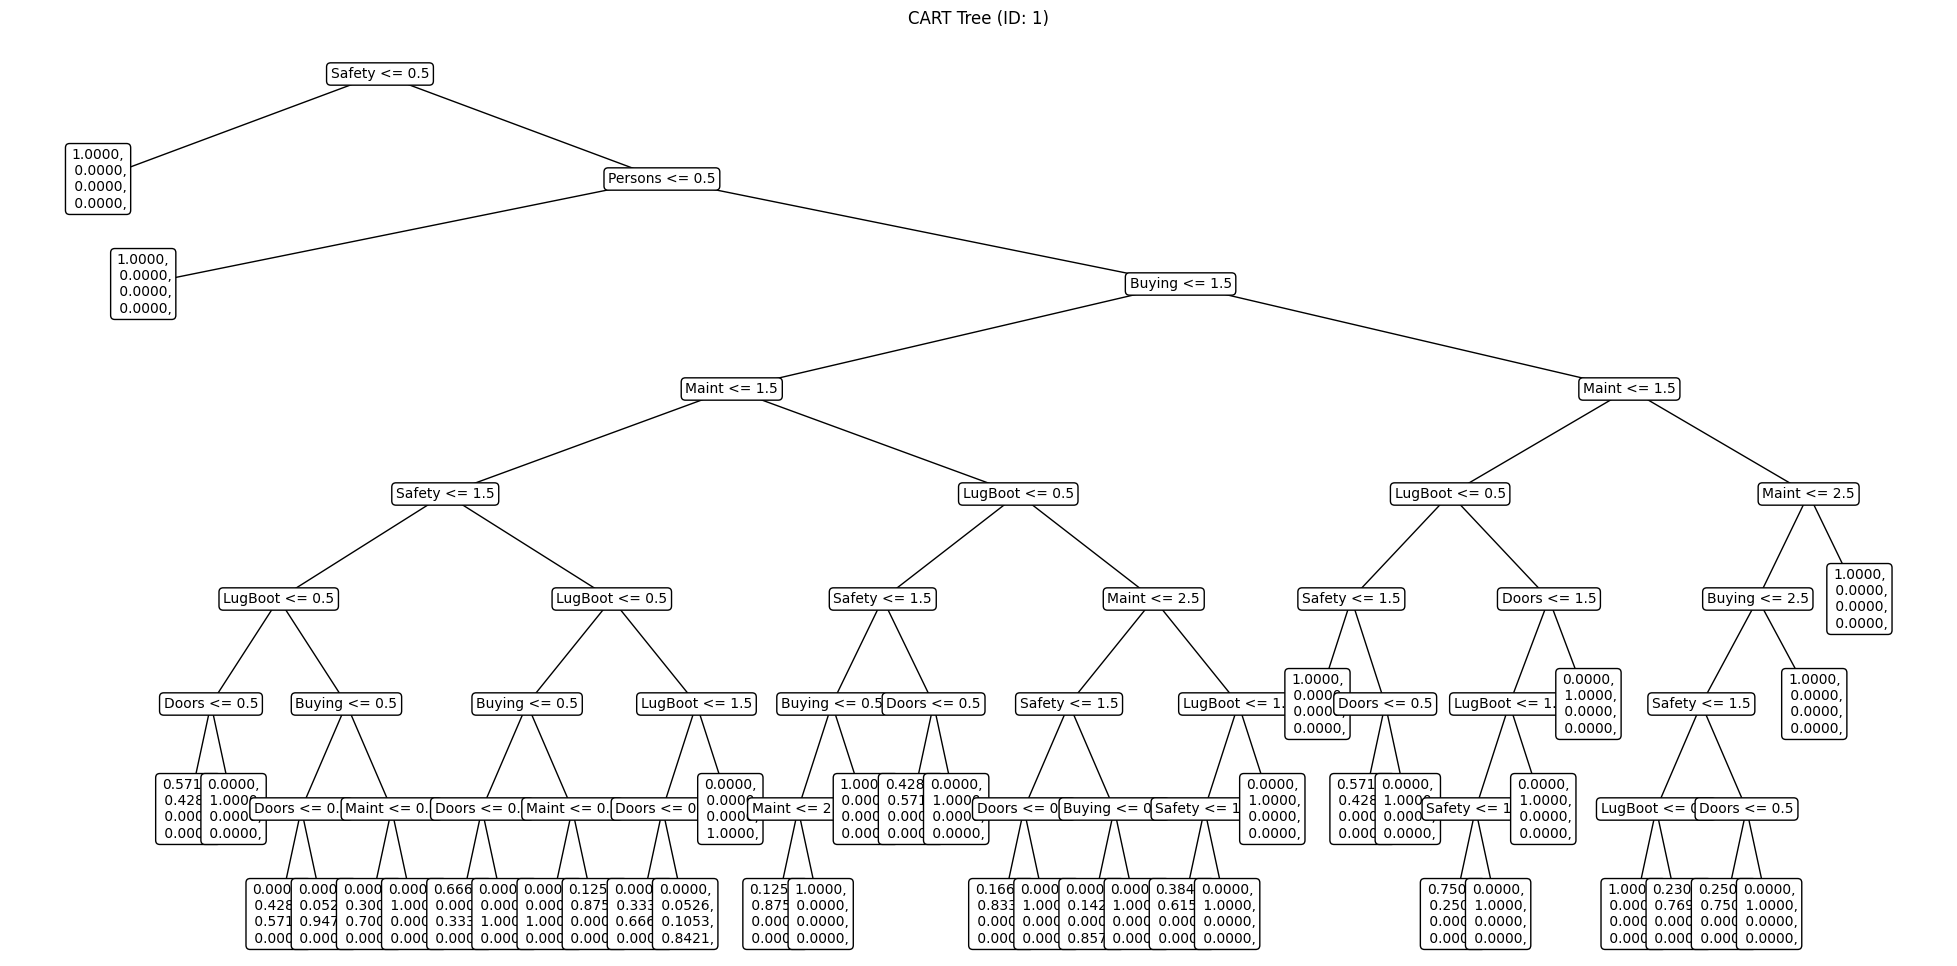

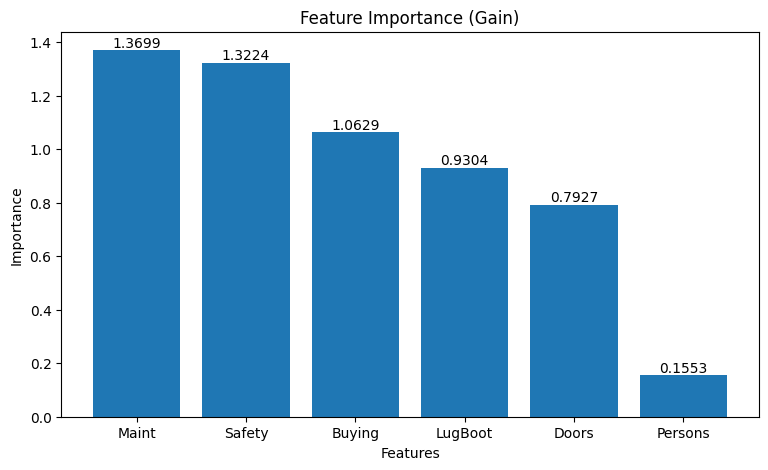

Model Config: {CART, gini Loss, NO Pruning}
Accuracy: 0.9624277456647399
Logloss: 0.26655550048470933
Confusion Matrix:
 [[229   4   1   0]
 [  3  78   2   1]
 [  1   0  15   1]
 [  0   0   0  11]]


In [ ]:
# Train your decision tree with different criteria - gini
# 

# Train a relatively good model using CART WITHOUT pruning
model1, acc, cfmatrix, logloss = tree_batch_classification(
    train_feature, test_feature, train_target, test_target, 
    num_classes = 4,
    loss = "gini",
    use = "my", 
    tree_id = 1,
    max_depth = 8,
    prune = False,
    random_state=2821,
    grid_accelerator=10,
    grid_use_percentile=True,
    grid_point_variant=0.05,
    feature_names = feature_names
)

# Evaluate performance on TEST SET.
print("Model Config: {CART, gini Loss, NO Pruning}")
print("Accuracy:", acc.data)
print("Logloss:", logloss.data)
print("Confusion Matrix:\n", cfmatrix.data)

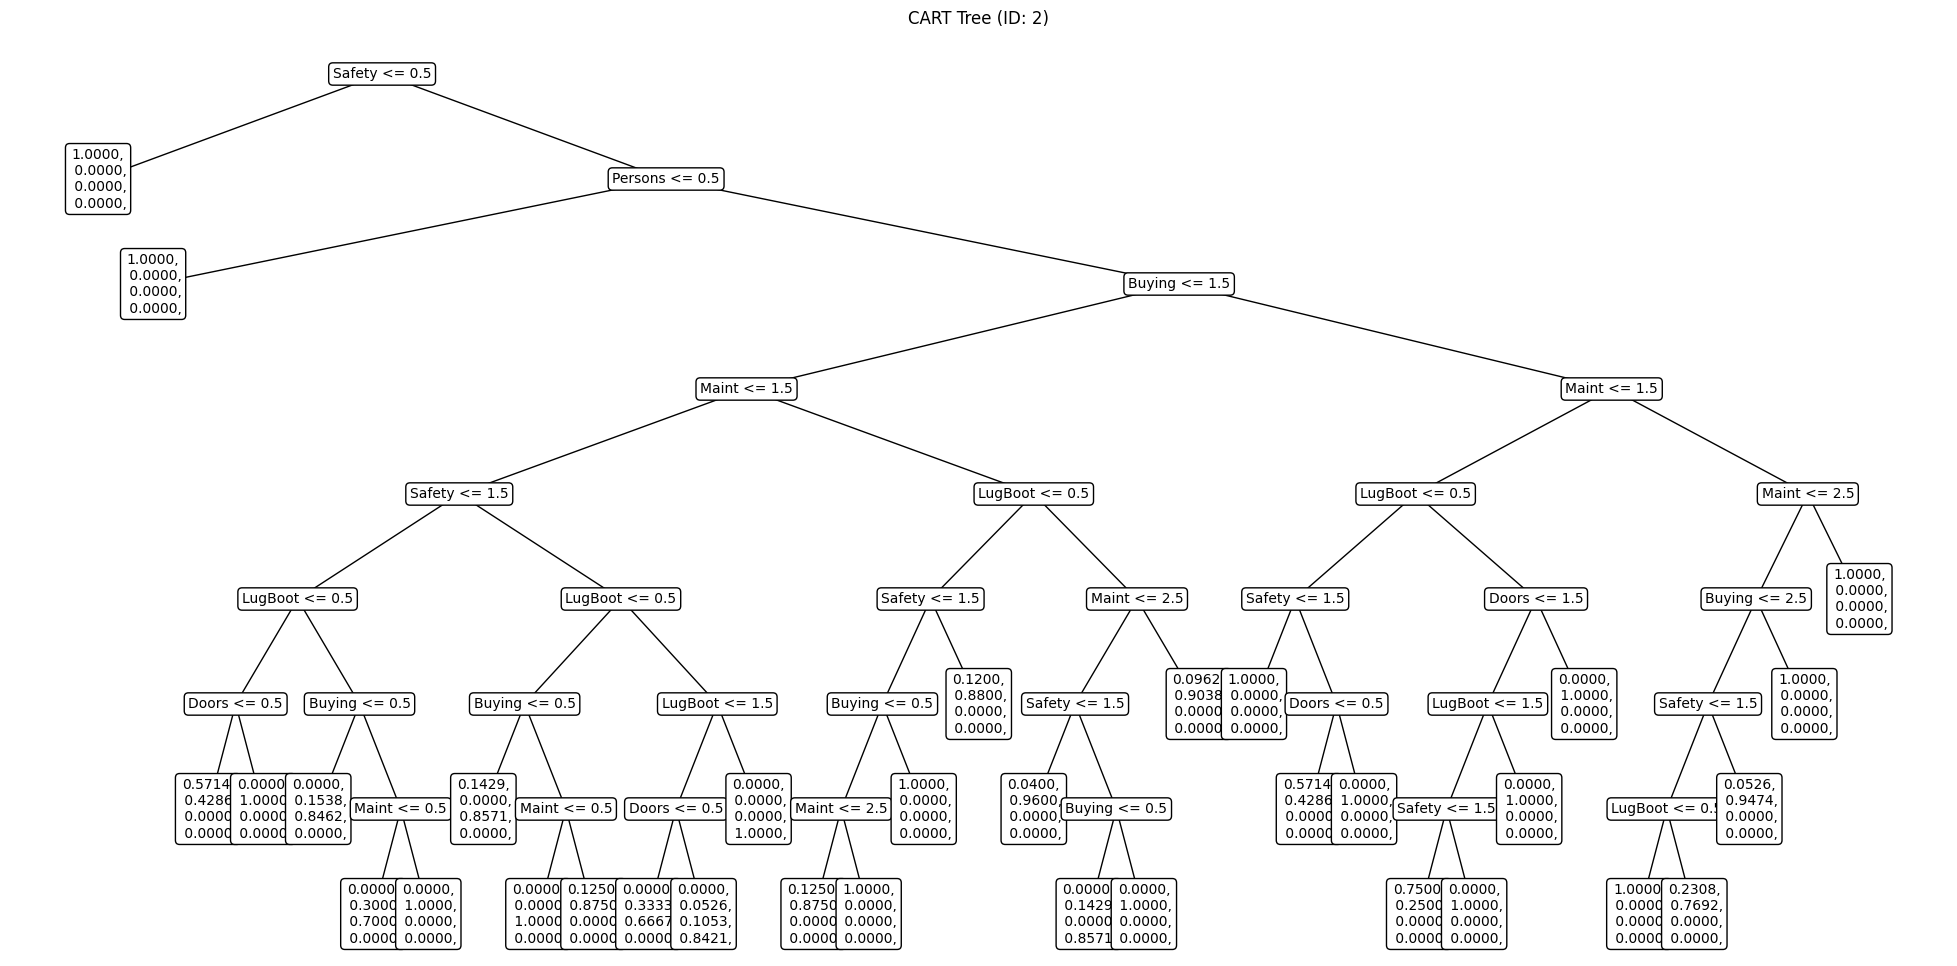

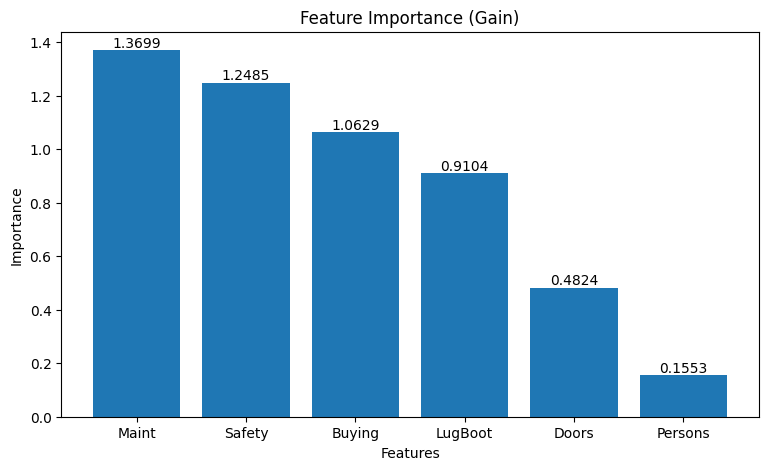

Model Config: {CART, gini Loss, WITH Pruning}
Accuracy: 0.9653179190751445
Logloss: 0.18853464043061893
Confusion Matrix:
 [[229   4   1   0]
 [  3  78   2   1]
 [  0   0  16   1]
 [  0   0   0  11]]


In [ ]:
# Train your decision tree with different criteria - gini
# 

# Train a relatively good model using CART WITH pruning
model2, acc, cfmatrix, logloss = tree_batch_classification(
    train_feature, test_feature, train_target, test_target, 
    num_classes = 4,
    loss = "gini",
    use = "my", 
    tree_id = 2,
    max_depth = 8,
    prune = True,
    prune_alpha=0.002,
    random_state=20252821,
    grid_accelerator=10,
    grid_use_percentile=True,
    grid_point_variant=0.05,
    feature_names = feature_names
)

# Evaluate performance on TEST SET.
print("Model Config: {CART, gini Loss, WITH Pruning}")
print("Accuracy:", acc.data)
print("Logloss:", logloss.data)
print("Confusion Matrix:\n", cfmatrix.data)

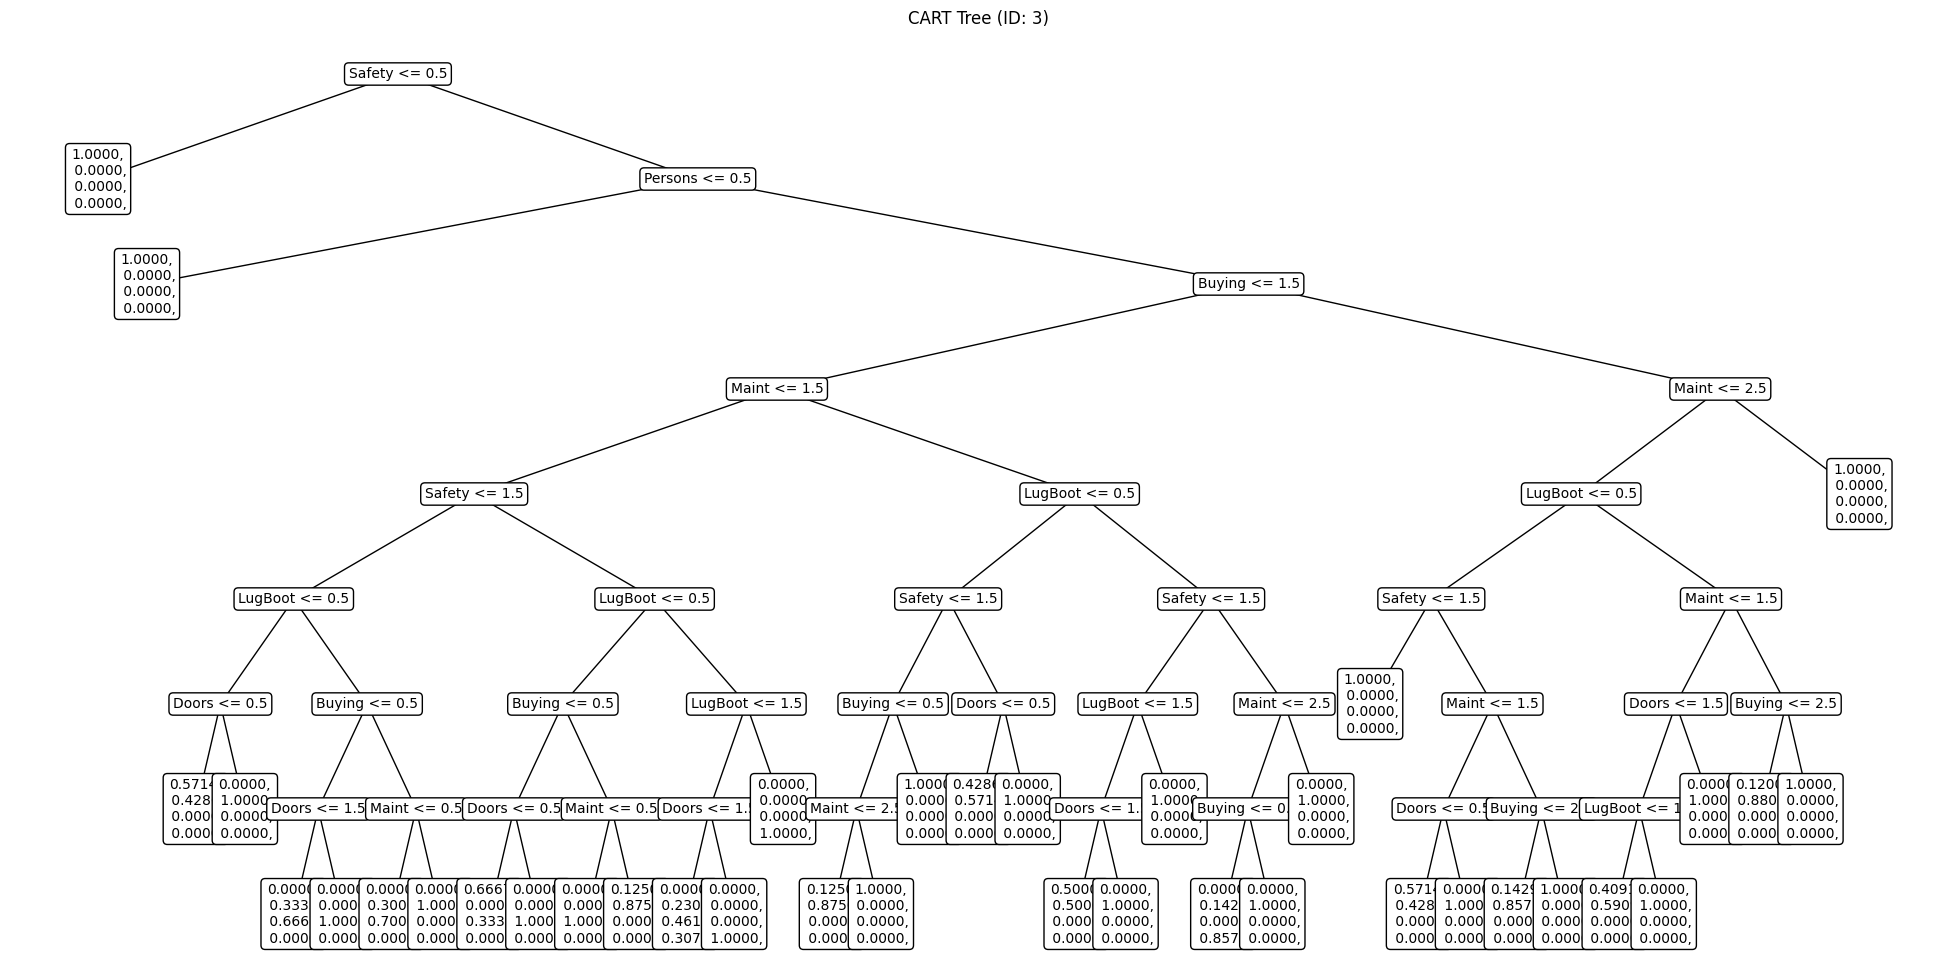

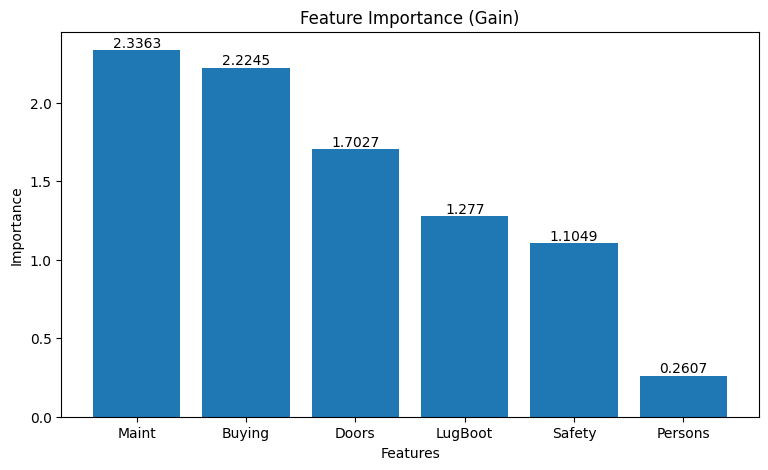

Model Config: {CART, cross-entropy Loss, WITH Pruning}
Accuracy: 0.9653179190751445
Logloss: 0.1674358258385196
Confusion Matrix:
 [[229   4   1   0]
 [  3  78   2   1]
 [  1   0  16   0]
 [  0   0   0  11]]


In [ ]:
# Train your decision tree with different criteria - logloss
# 

# Train a relatively good model using CART WITH pruning
model3, acc, cfmatrix, logloss = tree_batch_classification(
    train_feature, test_feature, train_target, test_target, 
    num_classes = 4,
    loss = "logloss",
    use = "my", 
    tree_id = 3,
    max_depth = 8,
    prune = True,
    prune_alpha=0.002,
    random_state=2821,
    grid_accelerator=10,
    grid_use_percentile=True,
    grid_point_variant=0.05,
    feature_names = feature_names
)

# Evaluate performance on TEST SET.
print("Model Config: {CART, cross-entropy Loss, WITH Pruning}")
print("Accuracy:", acc.data)
print("Logloss:", logloss.data)
print("Confusion Matrix:\n", cfmatrix.data)

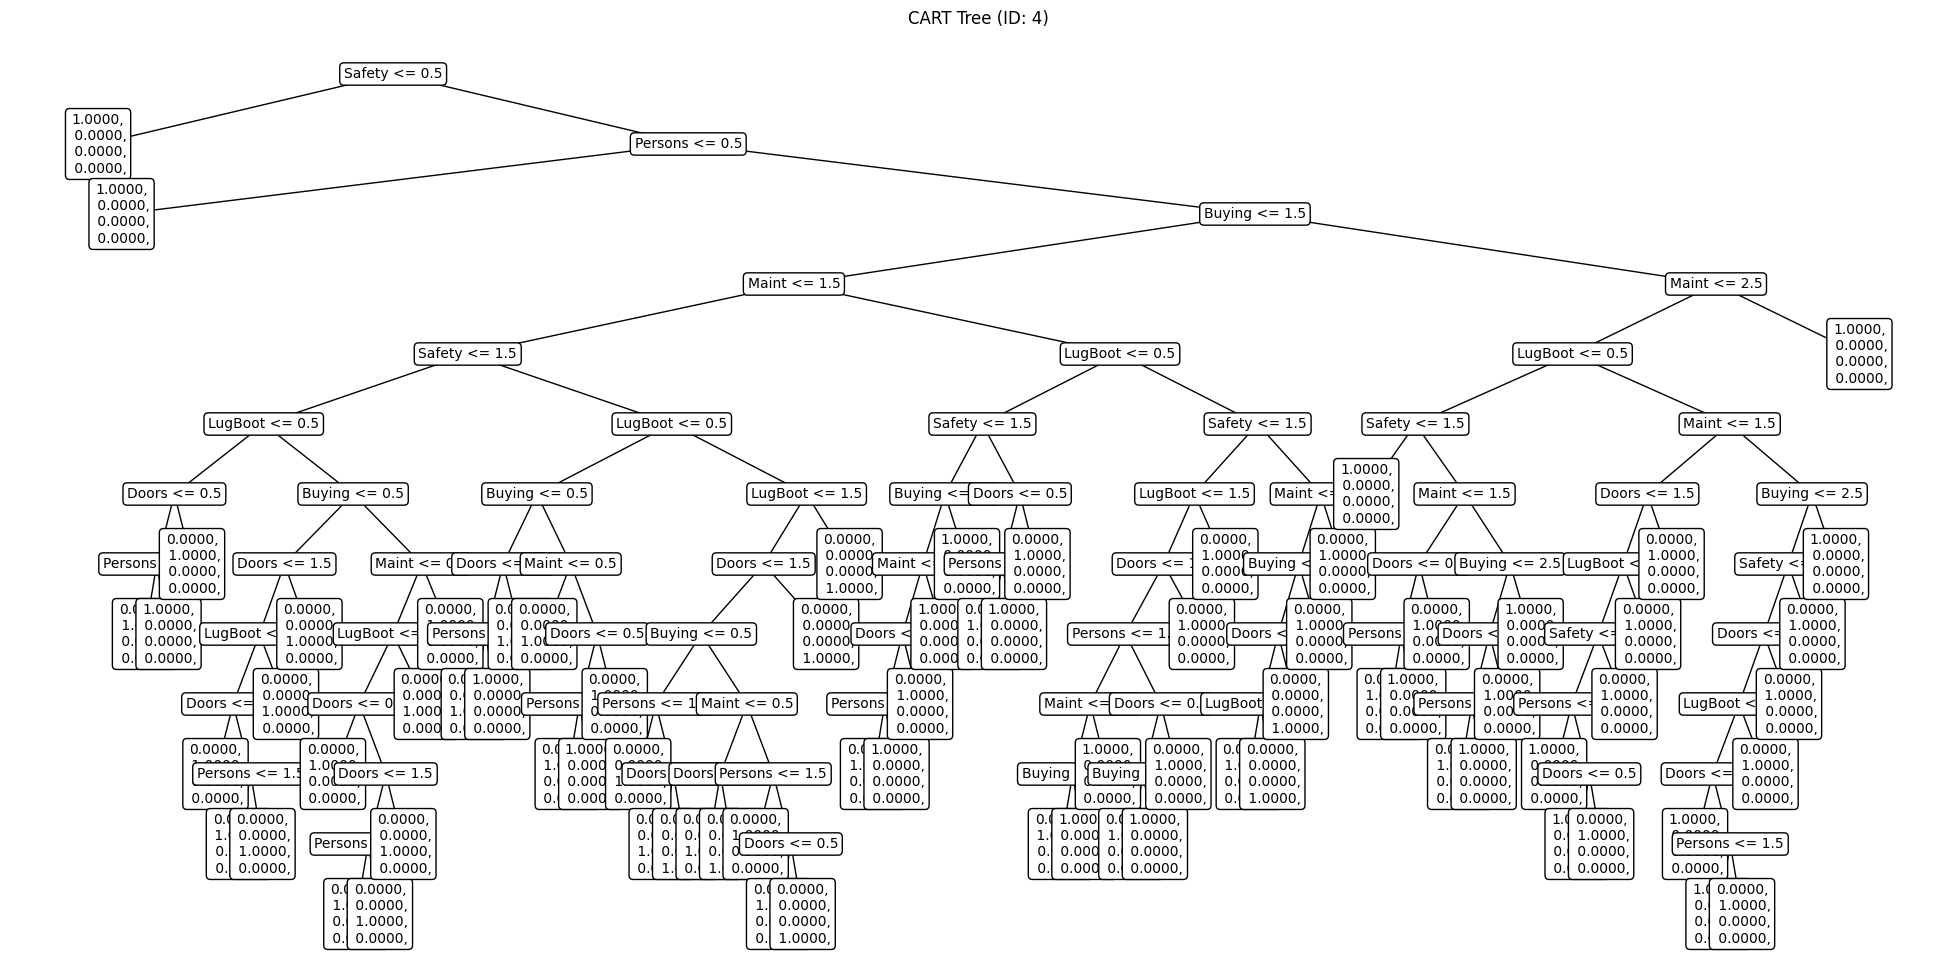

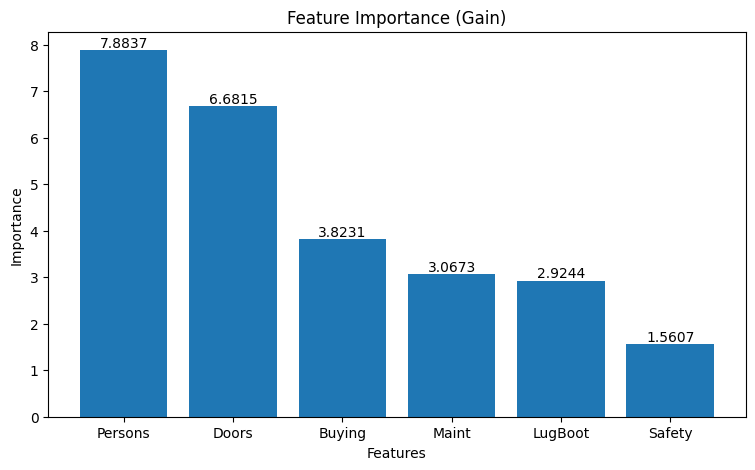

Model Config: {DEEP CART, cross-entropy Loss, WITH Pruning}
Accuracy: 0.9884393063583815
Logloss: 0.3992922126579279
Confusion Matrix:
 [[232   1   1   0]
 [  0  83   0   1]
 [  0   0  16   1]
 [  0   0   0  11]]


In [194]:
# Train your decision tree with different criteria - logloss - extremely deep tree with pruning
# 

# Train a relatively good model using CART WITH pruning
model4, acc, cfmatrix, logloss = tree_batch_classification(
    train_feature, test_feature, train_target, test_target, 
    num_classes = 4,
    loss = "logloss",
    use = "my", 
    tree_id = 4,
    max_depth = 25,
    prune = True,
    prune_alpha=0.0001,
    min_samples_split=2,
    random_state=2821,
    grid_accelerator=10,
    grid_use_percentile=True,
    grid_point_variant=0.05,
    feature_names = feature_names
)

# Evaluate performance on TEST SET.
print("Model Config: {DEEP CART, cross-entropy Loss, WITH Pruning}")
print("Accuracy:", acc.data)
print("Logloss:", logloss.data)
print("Confusion Matrix:\n", cfmatrix.data)

In [ ]:
# Example of saving the CART model to disk.
#

# |
# V De-comment this line to save the model.
# model4.save(model4, "./models/CART.ID04.bin")

In [ ]:
# Short Comparision
# 
# Sklearn Best - 0.9855  (Entropy, depth=25)
# 
# CART 1       - 0.9624  (Gini, depth= 8)
# CART 2       - 0.9653  (Gini, depth= 8, Pruned)
# CART 3       - 0.9653  (Entropy, depth= 8, Pruned)
# CART 4       - 0.9884  (Entropy, depth=25, Pruned)
#
# 1. Gini and Logloss performs equally well in multi-classification tasks, since we have categorical data.
# 2. Increasing the number of layers (the depth) generally performs better, but strongly depends on i.i.d assumption.
# 3. Pruning the tree may increase the performance, especially for cases with noises (but NOT for this).
# 4. My CART generally performs comparably to sklearn's Tree model. 
#    (Note, slightly worse in terms of accuracy when number of classes increases, like 10.)
#    (I don't know if sklearn's tree model is binomial or not.)

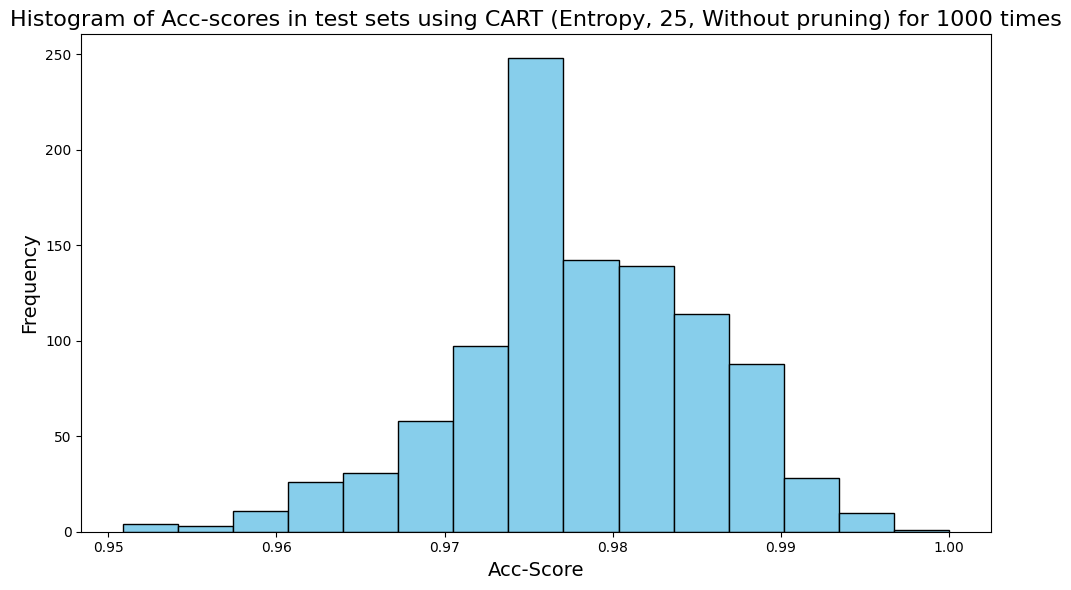

In [ ]:
# Robustness of prediction - Make seed and train-test set randomly selected
# 
acc_scores = []

# Create a task function.
def cart_robustness_test():

    # Randomly choose train-test set.
    train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
        features_car, targets_car, test_size=0.2, random_state=None)

    # Collect the f1-score using polynomial methods.
    model1, acc, cfmatrix, logloss = tree_batch_classification(
                train_feature, test_feature, train_target, test_target, 
                num_classes = 4,
                loss = "logloss",
                use = "my", 
                tree_id = 0,
                max_depth = 25,
                prune = True,
                prune_alpha=0.0000,
                min_samples_split=2,
                random_state=None,
                grid_accelerator=10,
                grid_use_percentile=True,
                grid_point_variant=0.05,
                feature_names = feature_names,
                plot_tree=False,
                plot_feature_importance=False,
            )

    acc_scores.append(acc.to_list())
    # Note!
    # This function is actually NOT thread-safe but let's ignore it since 
    # nothing too bad will happen even if there are some sync issues...

    return None

# Do CART with for 1000 times with random train-test sets.
for r in range(1000):
    cart_robustness_test()

# Plot a histogram of the acc-scores over repeated sampling.
acc_scores = pd.DataFrame({"acc_scores": acc_scores})

plt.figure(figsize=(10, 6))
plt.hist(acc_scores["acc_scores"], bins=15, color="skyblue", edgecolor="black")
plt.title("Histogram of Acc-scores in test sets using CART (Entropy, 25, Without pruning) for 1000 times", fontsize=16)
plt.xlabel("Acc-Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

`3. Analysis and Comparision`

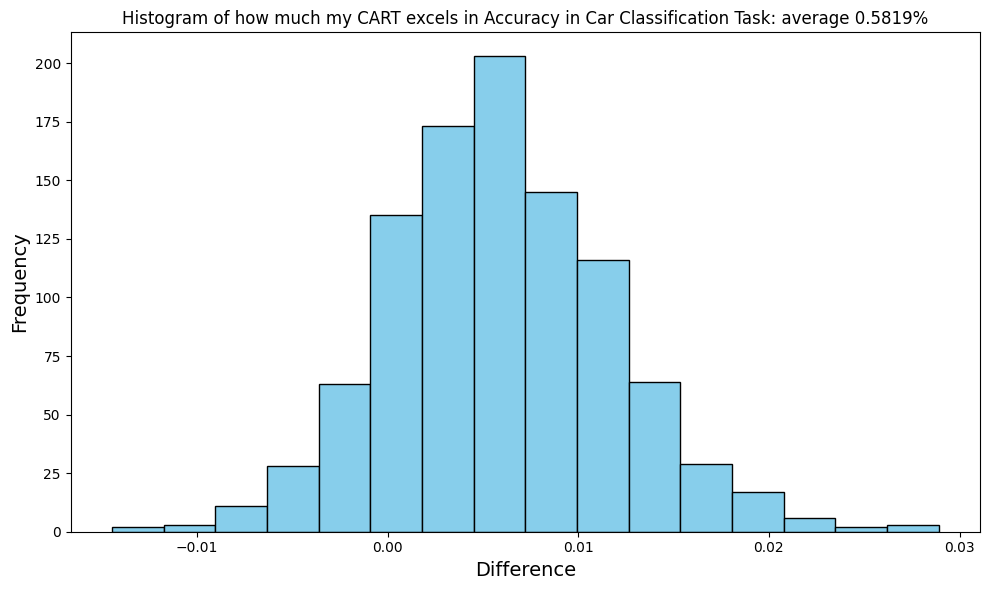

In [ ]:
# Compare my implementation with scikit-learn's DecisionTree
#
# We then still plot a difference histogram using our implementation and DecisionTree.

acc_score_diff =  []

def car_comparable_test_thread():

    # Randomly choose train-test set.
    train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
        features_car, targets_car, test_size=0.2, random_state=None)

    # Using my CART.
    _, acc, _, _ = tree_batch_classification(
                train_feature, test_feature, train_target, test_target, 
                num_classes = 4,
                loss = "logloss",
                use = "my", 
                tree_id = 0,
                max_depth = 25,
                prune = True,
                prune_alpha=0.0000,
                min_samples_split=2,
                random_state=None,
                grid_accelerator=10,
                grid_use_percentile=True,
                grid_point_variant=0.05,
                feature_names = feature_names,
                plot_tree=False,
                plot_feature_importance=False,
            )

    # Using sklearn DecisionTreeClassifier.
    _, sklacc, _, _ = tree_batch_classification(
        train_feature, test_feature, train_target, test_target, 
        num_classes = 4,
        loss = "logloss",
        use = "sklearn", 
        max_depth = 25,
        min_samples_split=4,
        random_state = None
    )

    acc_score_diff.append(acc.to_list() - sklacc.to_list())

for i in range(1000):
    car_comparable_test_thread()

# Plot the graph showing how my implementation excels.
my_beats = pd.DataFrame({"my_beats": acc_score_diff})
my_beats_mean = round(my_beats.mean()["my_beats"] * 100, 4)
plt.figure(figsize=(10, 6))
plt.hist(my_beats["my_beats"], bins=16, color="skyblue", edgecolor="black")
plt.title(f"Histogram of how much my CART excels in Accuracy in Car Classification Task: average {my_beats_mean}%", fontsize=12)
plt.xlabel("Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Compare my implementation with scikit-learn's SVC
#

# Sklearn Best - 0.9855  (Entropy, depth=25)
# 
# CART 1       - 0.9624  (Gini, depth= 8)
# CART 2       - 0.9653  (Gini, depth= 8, Pruned)
# CART 3       - 0.9653  (Entropy, depth= 8, Pruned)
# CART 4       - 0.9884  (Entropy, depth=25, Pruned)
# 
# Comparable Test:
# The metrics below evaluates how much my CART OUTPERFORMS Sklearn's Model
# > Mean:       0.5819%
# > Stdev:      0.6392%
# > Median:     0.5780%
# > Better %:    75.80%

# Conclusion:
# > Performance: On average, my CART implementation achieves a comparable level of performance in comparison with the sklearn's
#   Tree implementation. During the robustness test, statistical results exhibit that my CART even performs a little better than
#   sklearn's implementaion (on avaerage, excels 0.5819% in the car test, and in 758/1000 cases it performs better).
#   The outperformance may be due to the grid search technique, since randomness involved to prevent learning directly from data (overfitting)
#   but learning from patterns.
#  !However, in some other cases, like for a randomly generated classification task, my CART perform worse than sklearn's tree, on average, -0.4719%.
#   It should be noted that in that case, there are 1000 samples with 5 targets, while the samples are filled with noises.
#   It reminds me that the pruning technique should be refined in the future to achieve a better performance.
# 
# > Speed: I have tried my best to optimize the performance, in terms of doing optimization in Matrix and Tensor classes, as well as
#   in designing and implementing the CART class. With using grid search method, my implementation generally performs 25x slower than sklearns
#   in general tests. However, in this specific case, since all features are categorical values, which means the number of unique values for each
#   feature is limited, my CART performs relatively fast, although sklearn's model still runs faster.
#   In the specific case, my CART runs for approximately 0.3s while the SVC runs for less than 0.02s.
# 
# > Versatility: The reason why CART was the first tree I implemented is that it can perform both classification and regression tasks
#   so that it may be really used as some benchmark in the future. Sklearn has two different classes, while one is for classfication,
#   and one is for regression. Moreover, my implementation natively support plotting the tree structure and feature importance measured 
#   by gains in information improvement (information gain). These makes CART not only strong in metrics, but also strong in interpretability.
# 
# In a nutshell, although my implementation usually `costs significantly more time` to construct and split the tree, my CART
# implementation performs at least comparable to sklearn's classification trees in most of classfication tasks.
# The plotting functionality may further help researchers to understand the rules built by the model to achieve better transparency.

`End of Homework 2 Q1 by Nathmath Huang (bh2821)`